In [1]:
import os
import sys
import zipfile
import time
import random
import itertools
import math
import pandas as pd
import numpy as np
from scipy import stats, linalg
from scipy.stats import randint as sp_randint
import scipy.sparse
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab as pl
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, PolynomialFeatures, Normalizer
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC, OneClassSVM
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier, RandomTreesEmbedding, RandomForestClassifier, VotingClassifier, IsolationForest, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.neural_network import BernoulliRBM, MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, ExpSineSquared, ConstantKernel as CK, CompoundKernel, PairwiseKernel, WhiteKernel, Product, Exponentiation, Sum
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.kernel_approximation import RBFSampler, AdditiveChi2Sampler, Nystroem, SkewedChi2Sampler
from sklearn import mixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans, MiniBatchKMeans, FeatureAgglomeration, DBSCAN, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics.pairwise import chi2_kernel, laplacian_kernel, additive_chi2_kernel
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score, accuracy_score, recall_score, roc_auc_score, roc_curve, auc, consensus_score, brier_score_loss, log_loss
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, NMF, FactorAnalysis, FastICA, MiniBatchDictionaryLearning, TruncatedSVD, LatentDirichletAllocation
from sklearn.cross_decomposition import PLSCanonical, PLSSVD, PLSRegression, CCA
from sklearn import random_projection, manifold
from sklearn.manifold import TSNE
from sklearn.covariance import ShrunkCovariance, LedoitWolf, EmpiricalCovariance, MinCovDet, EllipticEnvelope
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif, RFECV, RFE, SelectKBest, chi2, mutual_info_classif, SelectFromModel, SelectFwe
from sklearn.feature_extraction.image import grid_to_graph
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion, make_union
from sklearn.calibration import CalibratedClassifierCV
import pywt
import cv2
import scipy.signal

import tensorflow as tf
import keras
from keras import backend as K, metrics as krmetrics, regularizers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Dropout, ZeroPadding2D, advanced_activations as AC, Reshape, Flatten, Embedding, Conv2D, Conv1D, GlobalMaxPooling2D, GlobalMaxPooling1D, MaxPooling2D, MaxPooling1D, AveragePooling2D, GlobalAveragePooling1D, LocallyConnected1D, AveragePooling1D, UpSampling2D, BatchNormalization, Lambda, Layer, Conv2DTranspose, LSTM, GRU, TimeDistributed, SimpleRNN, ConvLSTM2D, Permute, RepeatVector, Cropping1D, Cropping2D, Add, SeparableConv2D, LocallyConnected2D, Multiply, Concatenate, SeparableConv1D, CuDNNLSTM, CuDNNGRU, GlobalAveragePooling2D, ZeroPadding1D
from keras.layers.wrappers import Bidirectional
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras.regularizers import l2, l1
from keras import initializers
from keras.layers.noise import GaussianNoise, GaussianDropout
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.datasets import mnist, cifar10, cifar100, fashion_mnist
from keras.layers.advanced_activations import LeakyReLU
from keras import utils
from keras import activations
import keras.utils.np_utils as kutils
import json
import argparse
from scipy.optimize import minimize
from sklearn.metrics import log_loss
from keras.models import load_model, save_model, clone_model
import skimage.transform
from keras_contrib.callbacks import CyclicLR
from tensorflow.keras.utils import to_categorical

In [2]:
def get_session(devices="0", gpu_fraction=0.25):
    np.random.seed(random_state_tf)
    tf.compat.v1.set_random_seed(random_state_tf)
    os.environ["CUDA_VISIBLE_DEVICES"] = devices
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction, allow_growth=True)
    sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
    return sess

class CustomModelCheckpoint(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        if in_cv:
            self.ts_type = "cv" + str(n_cv)
        else:
            self.ts_type = "blind%s" % conf_permtest
        self.rocp = []
        self.f1 = []
        self.val_acc = []
        self.rfa = []
        self.df_hist = pd.DataFrame(columns=["epoch", "loss", "acc", "val_loss", "val_acc", "rocp", "f1", "rfa"])
        self.idx = 0
        self.best_epoch = 1

    def on_train_end(self, logs={}):
        print("\n======================BEST:======================")
        best_idx = self.best_epoch - 1
        print(self.df_hist.iloc[best_idx:best_idx + 1, :])
        if verbose_callback:
            print(self.df_hist)
            print(self.df_hist.describe())
        print("")

    def on_epoch_end(self, epoch, logs={}):
        if in_cv:
            x_val = x_test_dl
            y_val = y_test_dl[:, watch_cls]
        else:
            x_val = x_blind_dl
            y_val = y_blind_dl[:, watch_cls]
        label_out_pred_prob_d = model.predict(x_val)
        label_out_pred_d = np.argmax(label_out_pred_prob_d, axis=1)
        label_out_pred_m = label_out_pred_d
        label_out_pred = np.asarray(label_out_pred_m == watch_cls, dtype=np.int32)
        label_out_pred_prob = label_out_pred_prob_d[:, watch_cls]
        rocp = roc_auc_score(y_val, label_out_pred_prob)
        f1 = f1_score(y_val, label_out_pred)
        val_acc = logs.get("val_accuracy")
        acc = logs.get("accuracy")
        rfa = rocp * w_rocp + f1 * w_f1 + val_acc * w_acc
        self.df_hist.loc[self.idx] = [epoch + 1, logs.get("loss"), acc, logs.get("val_loss"), val_acc, rocp, f1, rfa]
        self.idx += 1
        if verbose_callback:
            print("======================EPOCH %06d:======================" % (epoch + 1))
            print(self.df_hist.iloc[self.idx - 1:self.idx, :])

        need_add = False
        if len(self.rfa) == 0 or rfa > np.max(self.rfa):
            need_add = True
        if need_add:
            self.rfa.append(rfa)
            if not verbose_callback:
                print("======================EPOCH %06d:======================" % (epoch + 1))
                print(self.df_hist.iloc[self.idx - 1:self.idx, :])
            print("RFA :", rfa)
            if save_histweights:
                model.save_weights(filepath_custom % (conf_tags_dl, self.ts_type, batch_size_cv, epoch, logs.get("loss"), acc, logs.get("val_loss"), val_acc, rocp, f1, rfa))
            if metric_save == "rfa":
                self.best_epoch = epoch + 1
                model.save_weights(save_dir + "/" + conf_tags_dl + "_%s.h5" % self.ts_type)

def lr_log(epoch):
    lr = model.optimizer.get_config()["learning_rate"]
    print('Learning rate: %0.8f' % lr)
    return lr

def lr_schedule(epoch):
    if epoch < int(epochs * lr_factors[0]):
        lr = lr_init
        return lr
    if epoch < int(epochs * lr_factors[1]):
        lr = lr_init * 0.1
        return lr
    if epoch < int(epochs * lr_factors[2]):
        lr = lr_init * 0.01
        return lr
    if epoch < int(epochs * lr_factors[3]):
        lr = lr_init * 0.001
        return lr
    lr = lr_init * 0.0001
    return lr

def huber_loss_mean(y_true, y_pred):
    clip_delta = 1.0
    error_abs = K.abs(y_true - y_pred)
    cond = error_abs < clip_delta
    squared_loss = 0.5 * K.square(error_abs)
    linear_loss = clip_delta * (error_abs - 0.5 * clip_delta)
    loss = tf.where(cond, squared_loss, linear_loss)
    loss = K.mean(loss)
    return loss

def xentropy_regu_mean(y_true, y_pred):
    e = 0.5
    loss1 = K.categorical_crossentropy(y_true, y_pred)
    loss2 = K.categorical_crossentropy(K.ones_like(y_pred) / num_classes, y_pred)
    return (1 - e) * loss1 + e * loss2

def linf_loss_batch(y_true, y_pred):
    ytf = K.flatten(y_true)
    ypf = K.flatten(y_pred)
    error_abs = K.abs(ytf - ypf)
    error_max = K.max(error_abs)
    return error_max

def xcustom_loss_batch(y_true, y_pred):
    loss = xentropy_regu_mean(y_true, y_pred)
    return loss

def clf_sigmoid(x):
    raw = 1.0 / (1 + np.exp(-x * 1.0))
    norm = preprocessing.normalize(raw, norm="l1")
    return norm

def plot_peaks(x, indexes, algorithm=None, mph=None, mpd=None):
    _, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(x, 'b', lw=1)
    if indexes.size:
        label = 'peak'
        label = label + 's' if indexes.size > 1 else label
        ax.plot(indexes, x[indexes], '+', mfc=None, mec='r', mew=2, ms=8, label='%d %s' % (indexes.size, label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    ax.set_xlim(-.02 * x.size, x.size * 1.02 - 1)
    ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
    yrange = ymax - ymin if ymax > ymin else 1
    ax.set_ylim(ymin - 0.1 * yrange, ymax + 0.1 * yrange)
    ax.set_xlabel('Data #', fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    ax.set_title('%s (mph=%s, mpd=%s)' % (algorithm, mph, mpd))
    plt.show()

pd.set_option('display.width', 1600)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 20)

random_state_tf = 2100

indata_dir = "."
indata_path = indata_dir + "/MMD_Diagnosis_Data.csv"

num_classes = 2
watch_cls = 1

img_rows, img_cols = 32, 32
channels = 1

bt_all = ['T1', 'T2', 'T3', 'T4', 'T5']

fs_core = 134
fs_core_idxs = np.arange(fs_core).tolist()
fs_ext = 0
fs_ext_idxs = (np.arange(fs_ext) + fs_core).tolist()
fs_num = fs_core + fs_ext

df_org = pd.read_csv(indata_path)
cols_core = np.array(df_org.columns[:fs_core], dtype=str)
df_fs_all = pd.DataFrame()
df_fs_all["fs_names"] = cols_core


In [3]:
conf_ds = "b51s2100v10s2100-stf_dn0mm10"
conf_tags = conf_ds

save_ds = False

split_mode = "RND"
bt_train = ['T1', 'T2', 'T3', 'T4']
ct_train = ['C1', 'C2', 'C3', 'C4']
n_splits = 5
split_no = 1
hdx_seed = 2100

cv_as_all = False
cv_mode = "RND"
n_cv_splits = 10
cv_seed = 2100
cv_partial = False
n_cv_partial = int(190 * n_cv_splits / (n_cv_splits - 1))
cv_partial_seed = 1000

fs_idxs = fs_core_idxs + fs_ext_idxs

dn_factor = None
minmax_scale = True
minmax_scale_factor = 10.0

conf_osbfb = "_osbfv2b"
conf_tags += conf_osbfb

train_ros = True
batch_fix = True
batch_fix_v2 = True
batch_fix_balance = True
osbfb_seed = 2100

m_dl = "mlite"
conf_dl = "_" + m_dl + "-d25_b32e200clr2lr01-85frpt"
conf_dl += "-v190s10"
conf_tags_dl = conf_tags + conf_dl

enable_dl = True
need_training_cv = True
cv_using_selflast = True
cv_using_selfbest = True
need_training_bl = True
bl_using_selflast = False
bl_using_selfbest = False
bl_using_cvbests = True
tb_enabled = False

if enable_dl:
    conf_tags += conf_dl

batch_size_cv = 32
epochs_cv = 200
batch_size = batch_size_cv
epochs = epochs_cv

metric_save = "rfa"
w_rocp = 0.3
w_f1 = 0.35
w_acc = 0.35
w_merge_exp_factor = 0.5

opt_name = "adam"
lr_init = 0.001
beta_1 = 0.75
sgd_decay = 5e-5

use_clr = True
if not use_clr:
    lr_factors = [0.4, 0.6, 0.8, 0.9]
else:
    step_mode = 'triangular'
    epochs_clr_cv = epochs_cv / 2 * 1 / 2
    epochs_clr = epochs / 2 * 1 / 2
    base_lr = 1e-7
    max_lr_cv = 0.01
    max_lr = max_lr_cv

data_augmentation = True
mix_enable = False
mix_alpha = 0.2
mix_datagen = False

show_model = True
verbose_dl = 2

conf_xk = "_l1"
if enable_dl:
    conf_xk += "d50"

enable_x = False
enable_sk = False
w_sk = 0.25
w_dl = 0.50

if enable_x or enable_sk:
    conf_tags += conf_xk

conf_extra = ""
conf_tags += conf_extra

print("\n===========================================================================\n")
print(conf_tags)
print("\n===========================================================================\n")

permtest_seed = "none"
if permtest_seed != "none":
    permtest_seed = int(permtest_seed)
    conf_permtest = "_PT" + str(permtest_seed)
    need_training_bl = True
    bl_using_selflast = False
    bl_using_selfbest = True
    bl_using_cvbests = False
    show_model = False
else:
    permtest_seed = None
    conf_permtest = ""




b51s2100v10s2100-stf_dn0mm10_osbfv2b_mlite-d25_b32e200clr2lr01-85frpt-v190s10




In [4]:
save_dir = os.path.join(os.path.dirname(os.path.abspath('288_test.ipynb')), 'saved_models_st_10cv/')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

if save_ds:
    outdata_dir = os.path.join(save_dir, conf_ds)
    if not os.path.isdir(outdata_dir):
        os.makedirs(outdata_dir)

log_dir = os.path.join(save_dir, conf_tags)
if not os.path.isdir(log_dir):
    os.makedirs(log_dir)

callbacks_dl = []

if not use_clr:
    lr_scheduler = LearningRateScheduler(lr_schedule)
    callbacks_dl.append(lr_scheduler)
else:
    callbacks_dl.append(None)

verbose_callback = False
save_histweights = False
model_name_custom = '%s_%s-b%03d.e%03d-l%0.3fd-a%0.3f-tl%0.3f-ta%0.3f-trp%0.3f-tf%0.3f-tw%0.3f.h5'
filepath_custom = os.path.join(save_dir, model_name_custom)
custom_checkpoint = CustomModelCheckpoint()
callbacks_dl.append(custom_checkpoint)

lr_logger = LearningRateScheduler(lr_log)
callbacks_dl += [lr_logger]

if tb_enabled:
    tb_dir = os.path.join(save_dir, conf_tags + "_tb")
    if not os.path.isdir(tb_dir):
        os.mkdir(tb_dir)
    tb_callback = keras.callbacks.TensorBoard(log_dir=tb_dir,
                                              write_graph=False,
                                              batch_size=batch_size,
                                              histogram_freq=epochs // 10,
                                              write_grads=True,
                                              write_images=False,
                                              update_freq='epoch',
                                              embeddings_freq=0,
                                              embeddings_layer_names=None,
                                              embeddings_data=None,
                                              )
    callbacks_dl += [tb_callback]
    if sys.platform.startswith("win"):
        os.system("start tensorboard --logdir %s" % tb_dir)
    else:
        os.system("setsid tensorboard --logdir %s >%s/stnew-tblog.txt 2>&1 &")

act_cnn = "AC.LeakyReLU()"

act_ds = "AC.LeakyReLU()"

bn_ct = True
bn_sc = True
rnn_impl = 0
unrolled = True

k_init = 'he_uniform'

k_regu = None
a_regu = None

def nl_denselayer(x_in, n_filter_dense, dense_drop_rate, triple_branch=False, branch_add_type="old", pre_act=False, concat_x=True, fully_concat=False, bn=True):
    if fully_concat:
        if triple_branch:
            n_branch = 3
        else:
            n_branch = 2
        if n_filter_dense % n_branch != 0:
            return None
        n_filter_internal = n_filter_dense // n_branch
    else:
        n_filter_internal = n_filter_dense

    x0 = x_in
    if not pre_act:
        xr = x0
    else:
        xr = Activation('relu')(x0)
    x0 = xr
    xr = Dense(n_filter_internal, activation="linear")(xr)
    xr = Activation('relu')(xr)
    xr = BatchNormalization(momentum=0.8)(xr)

    if fully_concat:
        xl1 = Dense(n_filter_internal, activation="linear")(x0)
    else:
        if branch_add_type == "old":
            xl1 = x0
        else:
            xl1 = Dense(n_filter_internal, activation="linear")(x0)
    xl2 = Dense(n_filter_internal, activation="linear")(x0)
    xm = Multiply()([xl1, xl2])
    xm = BatchNormalization(momentum=0.8)(xm)

    xt = Dense(n_filter_internal, activation="linear")(x0)
    xt = Activation('tanh')(xt)
    xs = Dense(n_filter_internal, activation="linear")(x0)
    xs = Activation('sigmoid')(xs)
    xts = Multiply()([xt, xs])

    if not fully_concat:
        if triple_branch:
            xn = Add()([xr, xm, xts])
        else:
            xn = Add()([xm, xts])
    else:
        if triple_branch:
            xn = Concatenate()([xr, xm, xts])
        else:
            xn = Concatenate()([xm, xts])
    if bn:
        xn = BatchNormalization(momentum=0.8)(xn)
    if not concat_x:
        x = Add()([x0, xn])
    else:
        x = Concatenate()([x0, xn])
    x = Dropout(dense_drop_rate)(x)

    return x

global model_showed
model_showed = False


In [5]:
def create_dlmodel(m_name=None):
    np.random.seed(random_state_tf)
    tf.compat.v1.set_random_seed(random_state_tf)

    if m_name is None:
        m_name = m_dl

    if opt_name=="adam":
        optimizer = Adam(lr=lr_init, beta_1=beta_1)
    elif opt_name=="adadelta":
        optimizer = keras.optimizers.Adadelta()
    else:
        optimizer = SGD(lr=lr_init, momentum=0.9, decay=sgd_decay, nesterov=True)

    losses_used="categorical"
    metrics_show = ['accuracy']

    #==========================================
    if m_name=="mnl":
        x_in = Input(shape=(img_rows,img_cols,1))

        n_filter_cur = 1024
        dense_drop_rate = 0.5

        x = x_in
        x = Flatten()(x)
        for i in range(1):
            for j in range(1): 
                x = nl_denselayer(x,int(n_filter_cur//1*1.0),dense_drop_rate,
                                  triple_branch=True,
                                  pre_act=False,concat_x=False,fully_concat=False,
                                  bn=False)
        x1 = x

        x = x_in
        x = Flatten()(x)
        
        for i in range(1):

            for j in range(2):
                x = nl_denselayer(x,int(n_filter_cur//1*1.0),dense_drop_rate,
                                  triple_branch=True,
                                  pre_act=False,concat_x=False,fully_concat=False,
                                  bn=False)
        x2 = x

        x = x_in
        x = Flatten()(x)
        for i in range(1):

            for j in range(3):
                x = nl_denselayer(x,int(n_filter_cur//1*1.0),dense_drop_rate,
                                  triple_branch=True,
                                  pre_act=False,concat_x=False,fully_concat=False,
                                  bn=False)
        x3 = x

        x = x_in
        x = Flatten()(x)
        for i in range(1):

            for j in range(4):
                x = nl_denselayer(x,int(n_filter_cur//1*1.0),dense_drop_rate,
                                  triple_branch=True,
                                  pre_act=False,concat_x=False,fully_concat=False, 
                                  bn=False)
        x4 = x

        x = x2

        prediction = Dense(num_classes,activation="softmax",
                           )(x)
        model = Model(x_in, prediction)
    #==========================================

    if m_name=="mlc":
        x_in = Input(shape=(img_rows,img_cols,1))
        x_top = Reshape((img_rows*img_cols,1))(x_in)

        x = x_top
        x = LocallyConnected1D(10, 30, padding="valid", strides=30)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(4, 10, padding="valid", strides=10)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(2, 4, padding="valid", strides=4)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 2, padding="valid", strides=2)(x)
        x1 = x

        x = x_top
        x = LocallyConnected1D(10, 36, padding="valid", strides=36)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(3, 10, padding="valid", strides=10)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 3, padding="valid", strides=3)(x)
        x2 = x

        x = x_top
        x = LocallyConnected1D(9, 25, padding="valid", strides=25)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(4, 9, padding="valid", strides=9)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(2, 4, padding="valid", strides=4)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 2, padding="valid", strides=2)(x)
        x3 = x

        x = x_top
        x = LocallyConnected1D(8, 18, padding="valid", strides=18)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(4, 8, padding="valid", strides=8)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(2, 4, padding="valid", strides=4)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 2, padding="valid", strides=2)(x)
        x4 = x

        x = x_top
        x = LocallyConnected1D(12, 45, padding="valid", strides=45)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(4, 12, padding="valid", strides=12)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(2, 4, padding="valid", strides=4)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 2, padding="valid", strides=2)(x)
        x5 = x

        x1 = Dropout(0.25)(x1)
        x2 = Dropout(0.25)(x2)
        x3 = Dropout(0.25)(x3)
        x4 = Dropout(0.25)(x4)
        x5 = Dropout(0.25)(x5)
        x1 = Flatten()(x1)
        x2 = Flatten()(x2)
        x3 = Flatten()(x3)
        x4 = Flatten()(x4)
        x5 = Flatten()(x5)
        x = Concatenate()([x1,x2,x3,x4,x5])

        z = x

        prediction = Dense(num_classes,
                  kernel_initializer=k_init,
                  activation="softmax")(z)
        model = Model(x_in, prediction)
    #==========================================

    #==========================================
    if m_name=="mlcn2":
        x_in = Input(shape=(img_rows,img_cols,1))
        x_top = Reshape((-1,1))(x_in)

        x = x_top
        x = LocallyConnected1D(10, 30, padding="valid", strides=30)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(4, 10, padding="valid", strides=10)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(2, 4, padding="valid", strides=4)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 2, padding="valid", strides=2)(x)
        x1 = x

        x = x_top
        x = LocallyConnected1D(10, 36, padding="valid", strides=36)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(3, 10, padding="valid", strides=10)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 3, padding="valid", strides=3)(x)
        x2 = x

        x = x_top
        x = LocallyConnected1D(9, 25, padding="valid", strides=25)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(4, 9, padding="valid", strides=9)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(2, 4, padding="valid", strides=4)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 2, padding="valid", strides=2)(x)
        x3 = x

        x = x_top
        x = LocallyConnected1D(8, 18, padding="valid", strides=18)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(4, 8, padding="valid", strides=8)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(2, 4, padding="valid", strides=4)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 2, padding="valid", strides=2)(x)
        x4 = x

        x = x_top
        x = LocallyConnected1D(12, 45, padding="valid", strides=45)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(4, 12, padding="valid", strides=12)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(2, 4, padding="valid", strides=4)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 2, padding="valid", strides=2)(x)
        x5 = x

        x1 = Flatten()(x1)
        x2 = Flatten()(x2)
        x3 = Flatten()(x3)
        x4 = Flatten()(x4)
        x5 = Flatten()(x5)

        x0 = x1
        x0d = Dropout(0.25)(x0)
        x0t = Dense(34,activation="tanh")(x0)
        x0s = Dense(34,activation="sigmoid")(x0)
        x0l = Dense(34,activation="linear")(x0)
        xm = Multiply()([x0,x0l])
        xm = Dropout(0.25)(xm)
        xts = Multiply()([x0t,x0s])
        xts = Dropout(0.25)(xts)
        x1 = Add()([x0d,xm,xts])

        x0 = x2
        x0d = Dropout(0.25)(x0)
        x0t = Dense(28,activation="tanh")(x0)
        x0s = Dense(28,activation="sigmoid")(x0)
        x0l = Dense(28,activation="linear")(x0)
        xm = Multiply()([x0,x0l])
        xm = Dropout(0.25)(xm)
        xts = Multiply()([x0t,x0s])
        xts = Dropout(0.25)(xts)
        x2 = Add()([x0d,xm,xts])

        x0 = x3
        x0d = Dropout(0.25)(x0)
        x0t = Dense(40,activation="tanh")(x0)
        x0s = Dense(40,activation="sigmoid")(x0)
        x0l = Dense(40,activation="linear")(x0)
        xm = Multiply()([x0,x0l])
        xm = Dropout(0.25)(xm)
        xts = Multiply()([x0t,x0s])
        xts = Dropout(0.25)(xts)
        x3 = Add()([x0d,xm,xts])

        x0 = x4
        x0d = Dropout(0.25)(x0)
        x0t = Dense(56,activation="tanh")(x0)
        x0s = Dense(56,activation="sigmoid")(x0)
        x0l = Dense(56,activation="linear")(x0)
        xm = Multiply()([x0,x0l])
        xm = Dropout(0.25)(xm)
        xts = Multiply()([x0t,x0s])
        xts = Dropout(0.25)(xts)
        x4 = Add()([x0d,xm,xts])

        x0 = x5
        x0d = Dropout(0.25)(x0)
        x0t = Dense(22,activation="tanh")(x0)
        x0s = Dense(22,activation="sigmoid")(x0)
        x0l = Dense(22,activation="linear")(x0)
        xm = Multiply()([x0,x0l])
        xm = Dropout(0.25)(xm)
        xts = Multiply()([x0t,x0s])
        xts = Dropout(0.25)(xts)
        x5 = Add()([x0d,xm,xts])

        x_p1 = Concatenate()([x1,x2,x3,x4,x5])

        x0 = x_p1
        x0d = Dropout(0.25)(x0)
        x0t = Dense(180,activation="tanh")(x0)
        x0s = Dense(180,activation="sigmoid")(x0)
        x0l = Dense(180,activation="linear")(x0)
        xm = Multiply()([x0,x0l])
        xm = Dropout(0.25)(xm)
        xts = Multiply()([x0t,x0s])
        xts = Dropout(0.25)(xts)
        x_p1 = Add()([x0d,xm,xts])
        x = x_p1

        x = Activation('relu')(x) 
        x = Dropout(0.25)(x) 

        z = x

        prediction = Dense(num_classes,
                   kernel_initializer=k_init,
                   activation="softmax"
                  )(z)
        model = Model(x_in, prediction)
    #==========================================

    ##==========================================
    if m_name=="ml2c12":
        drop_rate = 0.25 
        mid_drop_rate = 0.25
        dense_drop_rate = 0.25 

        n_filters_c12 = 64 
        drop_rate_c12 = 0.25 
        add_drop_rate_c12 = 0.25
        dense_drop_rate_c12 = 0.25

        x_in = Input(shape=(img_rows,img_cols,1))
        x_top = Reshape((img_rows*img_cols,1))(x_in)

        x = x_top
        x = LocallyConnected1D(12, 32, padding="valid", strides=32)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(5, 12, padding="valid", strides=12)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(2, 5, padding="valid", strides=5)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 2, padding="valid", strides=2)(x)
        x1 = x

        x = x_top
        x = LocallyConnected1D(15, 42, padding="valid", strides=42)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(6, 15, padding="valid", strides=15)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(2, 6, padding="valid", strides=6)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 2, padding="valid", strides=2)(x)
        x2 = x

        x = x_top
        x = LocallyConnected1D(9, 22, padding="valid", strides=22)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(4, 9, padding="valid", strides=9)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(2, 4, padding="valid", strides=4)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 2, padding="valid", strides=2)(x)
        x3 = x

        x = x_top
        x = LocallyConnected1D(7, 18, padding="valid", strides=18)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(3, 7, padding="valid", strides=7)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(2, 3, padding="valid", strides=3)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 2, padding="valid", strides=2)(x)
        x4 = x

        x = x_top
        x = LocallyConnected1D(20, 46, padding="valid", strides=46)(x) #6/30 15
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(7, 20, padding="valid", strides=20)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(2, 7, padding="valid", strides=7)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(1, 2, padding="valid", strides=2)(x)
        x5 = x

        x1 = Dropout(drop_rate)(x1)
        x2 = Dropout(drop_rate)(x2)
        x3 = Dropout(drop_rate)(x3)
        x4 = Dropout(drop_rate)(x4)
        x5 = Dropout(drop_rate)(x5)
        x1 = Flatten()(x1)
        x2 = Flatten()(x2)
        x3 = Flatten()(x3)
        x4 = Flatten()(x4)
        x5 = Flatten()(x5)
        x1l = x1
        x2l = x2
        x3l = x3
        x4l = x4
        x5l = x5

        triple_branch=False 
        branch_add_type="new" 
        pre_act=False 
        concat_x=False 
        fully_concat=False 
        bn=False 

        n_filters_nl=32 
        for i in range(1): 
            x1 = nl_denselayer(x1,n_filters_nl,mid_drop_rate,
                               triple_branch=triple_branch,
                               branch_add_type=branch_add_type,
                               pre_act=pre_act,concat_x=concat_x,fully_concat=fully_concat,
                               bn=bn) 

        n_filters_nl=24
        for i in range(1): 
            x2 = nl_denselayer(x2,n_filters_nl,mid_drop_rate,
                               triple_branch=triple_branch,
                               branch_add_type=branch_add_type,
                               pre_act=pre_act,concat_x=concat_x,fully_concat=fully_concat,
                               bn=bn) 

        n_filters_nl=46
        for i in range(1):
            x3 = nl_denselayer(x3,n_filters_nl,mid_drop_rate,
                               triple_branch=triple_branch,
                               branch_add_type=branch_add_type,
                               pre_act=pre_act,concat_x=concat_x,fully_concat=fully_concat,
                               bn=bn)

        n_filters_nl=56
        for i in range(1): 
            x4 = nl_denselayer(x4,n_filters_nl,mid_drop_rate,
                               triple_branch=triple_branch,
                               branch_add_type=branch_add_type,
                               pre_act=pre_act,concat_x=concat_x,fully_concat=fully_concat,
                               bn=bn) 

        n_filters_nl=22
        for i in range(1): 
            x5 = nl_denselayer(x5,n_filters_nl,mid_drop_rate,
                               triple_branch=triple_branch,
                               branch_add_type=branch_add_type,
                               pre_act=pre_act,concat_x=concat_x,fully_concat=fully_concat,
                               bn=bn)

        x = Concatenate()([x1,x2,x3,x4,x5])

        n_filters_nl=180
        for i in range(1): 
            x = nl_denselayer(x,n_filters_nl,0,
                              triple_branch=False,
                              branch_add_type="new",
                              pre_act=False,concat_x=False,fully_concat=False,
                              bn=False)
        x = Activation('relu')(x)
        x = Dropout(dense_drop_rate)(x)
        zmln2nb = x


        x = Concatenate()([x1l,x2l,x3l,x4l,x5l])

        n_filters_nl=180 
        for i in range(1): 
            x = nl_denselayer(x,n_filters_nl,0,
                              triple_branch=False,
                              branch_add_type="old",
                              pre_act=False,concat_x=False,fully_concat=False, 
                              bn=True) 
        x = Activation('relu')(x)
        x = Dropout(dense_drop_rate)(x)
        zmlob = x


        x = x_top
        x = Conv1D(n_filters_c12,16,padding='same',strides=4)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)
        x = Dropout(drop_rate_c12)(x)
        x = Conv1D(n_filters_c12,8,padding='same',strides=4)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)
        x = Dropout(drop_rate_c12)(x)
        x = Conv1D(n_filters_c12,4,padding='same',strides=4)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)
        x = Dropout(drop_rate_c12)(x)
        x = Flatten()(x)
        z1 = x

        x = Reshape((n_filters_c12,img_rows*img_cols//n_filters_c12,1))(x_in)
        x = Conv2D(n_filters_c12,(3, 8),padding='same',strides=(1,4))(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)
        x = Dropout(drop_rate_c12)(x)
        x = Conv2D(n_filters_c12,(3, 4),padding='same',strides=(2,4))(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)
        x = Dropout(drop_rate_c12)(x)
        x = Conv2D(n_filters_c12,(3, 1),padding='same',strides=(2,1))(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)
        x = Dropout(drop_rate_c12)(x)
        x = Flatten()(x)
        z2 = x

        x = Add()([z1,z2])
        x = Dropout(add_drop_rate_c12)(x)
        n_filters_dense_c12=n_filters_c12 
        for i in range(1):
            x = nl_denselayer(x,n_filters_dense_c12,dense_drop_rate_c12,
                              triple_branch=False,
                              branch_add_type="new",
                              pre_act=False,concat_x=True,fully_concat=False, 
                              bn=True) 
        z12 = x


        x = Concatenate()([zmln2nb,zmlob,z12]) 

        prediction = Dense(num_classes,activation="softmax")(x)
        model = Model(x_in, prediction)

    if m_name=="mlite":
        n_filters_nl = 96 
        drop_rate = 0.25 

        x_in = Input(shape=(img_rows,img_cols,1))

        x = Reshape((-1,1))(x_in)
        x = LocallyConnected1D(18, 32, padding="valid", strides=32)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(9, 18, padding="valid", strides=18)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(5, 9, padding="valid", strides=9)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(3, 5, padding="valid", strides=5)(x)
        x = Flatten()(x)

        x0 = x
        x0d = Dropout(drop_rate)(x0)
        x0t = Dense(n_filters_nl,activation="tanh")(x0)
        x0s = Dense(n_filters_nl,activation="sigmoid")(x0)
        x0l = Dense(n_filters_nl,activation="linear")(x0)
        xm = Multiply()([x0,x0l])
        xm = Dropout(drop_rate)(xm)
        xts = Multiply()([x0t,x0s])
        xts = Dropout(drop_rate)(xts)
        x = Add()([x0d,xm,xts])

        prediction = Dense(num_classes,
                   kernel_initializer=k_init,
                   activation="softmax"
                  )(x)
        model = Model(x_in, prediction)

    if m_name=="mlitev2":
        n_filters_nl = 128
        drop_rate = 0.25 

        x_in = Input(shape=(img_rows,img_cols,1))
        x_top = Reshape((img_rows*img_cols,1))(x_in)

        x = Reshape((-1,1))(x_top)
        x = LocallyConnected1D(16, 32, padding="valid", strides=32)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(8, 16, padding="valid", strides=16)(x)
        x = Reshape((-1,1))(x)
        x = LocallyConnected1D(4, 8, padding="valid", strides=8)(x)
        x = Flatten()(x)
        x = Dropout(drop_rate)(x)

        for i in range(1): 
            x = nl_denselayer(x,n_filters_nl,drop_rate,
                              triple_branch=True,
                              branch_add_type="old",
                              pre_act=False,concat_x=False,fully_concat=False,
                              bn=False) 


        prediction = Dense(num_classes,activation="softmax")(x)
        model = Model(x_in, prediction)
    #==========================================
    if m_name=="mglr":
        x_in = Input(shape=(img_rows,img_cols,1))
        x_top = Reshape((-1,1))(x_in)

        x = x_top
        x = LocallyConnected1D(15, 32, padding="valid", strides=32)(x)
        x = Reshape((-1,1))(x)
        x1 = LocallyConnected1D(10, 15, padding="valid", strides=15)(x)

        x1 = Activation("relu")(x1)
        x1 = Conv1D(32, 1, padding='same', strides=1)(x1)
        x1 = Conv1D(32, 1, padding='same', strides=1)(x1)

        x = x_top
        x = Conv1D(32, 32, padding='same', strides=8)(x)
        x2 = Conv1D(32, 16, padding='same', strides=4)(x)

        x2 = Activation("relu")(x2)

        x = Concatenate()([x1,x2])
        x = Bidirectional(LSTM(32,
                 return_sequences=True))(x)
        x = Conv1D(32, 3, padding='same', strides=3)(x)
        x = Conv1D(32, 3, padding='same', strides=3)(x)
        x = Flatten()(x)

        z = x

        prediction = Dense(num_classes,
                   kernel_initializer=k_init,
                   activation="softmax"
                  )(z)
        model = Model(x_in, prediction)

    global model_showed
    if show_model and not model_showed:
        model.summary()

        model_showed = True

    if losses_used=="sparse":
        model.compile(optimizer=optimizer,
                      loss=keras.losses.sparse_categorical_crossentropy,
                      metrics=metrics_show)
    if losses_used=="categorical":
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=metrics_show)
    return model

model = None


crop_prob = -0.01
crop_factor = 0.80
crop_factor_ub = 1.0 
crop_fill_mode = "constant"
crop_strict=False
crop_preserve_range=False 
crop_anti_aliasing=False 

from random_eraser import get_random_eraser
random_eraser = get_random_eraser(p=0.85, 
                                  s_l=0.02, s_h=0.4,
                                  r_1=0.3, r_2=1/0.3, 
                                  v_l=-1.0*minmax_scale_factor/1.0, 
                                  v_h= 1.0*minmax_scale_factor/1.0,
                                  pixel_level=True) 

zoom_fill_mode = "constant"  
zoom_fill_val = -1*minmax_scale_factor if minmax_scale else 0

def random_crop_image(image):
    skip_crop = np.random.random()
    if skip_crop<=(1-crop_prob):
        image_crop = image
    else:
        random_array = np.random.random(size=4)
        height,width,channels = image.shape
        if not crop_strict:
            w = int(width*(crop_factor+random_array[0]*(crop_factor_ub-crop_factor)))
        else:
            w = int((width*crop_factor)*(1+random_array[0]*(1-crop_factor)))
        h = w
        x = int(random_array[2]*(width-w))
        y = int(random_array[3]*(height-h))
        image_crop = image[y:h+y,x:w+x,0:channels]
        image_crop = skimage.transform.resize(image_crop,image.shape,
                                              preserve_range=crop_preserve_range,
                                              anti_aliasing=crop_anti_aliasing,
                                              mode=crop_fill_mode,
                                              )
    image_crop=random_eraser(image_crop)
    return image_crop

datagen = ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False,
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False,
    zca_whitening=False, 
    zca_epsilon=1e-06,

    fill_mode=zoom_fill_mode,
    cval=zoom_fill_val, 
    brightness_range=None, 
    channel_shift_range=0.0, 
    preprocessing_function=random_crop_image, 
    rescale=None,
    data_format='channels_last',
    validation_split=0.0,
    dtype=np.float32)


import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import xgboost as xgb

eval_metric = ["merror"] 

param_xgb = {'max_depth':7, 'learning_rate':0.02, 
         'silent':True, 'verbose':0, 'seed':2100,
         'objective':'multi:softmax','num_class':num_classes,
         'booster':'gbtree',
         'grow_policy':'lossguide', 
         'alpha': 0.0001, 'lambda': 0.5, 
         'gamma':0.001, 'min_child_weight':1.0, 
         'subsample':0.8, 'colsample_bytree':0.8, 
         'scale_pos_weight':1,'max_delta_step':1,
         'nthread':4, 'eval_metric':eval_metric}

num_round_xgb = 625
ntree_limit = 0


random_state = 2100

rf = RandomForestClassifier(n_estimators=150, criterion='gini',
                       max_depth=5, min_samples_split=5, oob_score=False,
                       random_state=random_state)

gbdt = GradientBoostingClassifier(n_estimators=500, max_depth=2, max_features="auto",
                          learning_rate=0.4, subsample=1.0,random_state=random_state)

feed=linear_model.LogisticRegression(dual=False,C=100,penalty='l2',n_jobs=1,
                                     max_iter=5000,solver="lbfgs",random_state=random_state)
ada = AdaBoostClassifier(feed,algorithm="SAMME.R", 
                              n_estimators=100,learning_rate=0.1,
                              random_state=random_state)

feed=linear_model.LogisticRegression(dual=False,C=10.2,penalty='l1',n_jobs=1,
                                     max_iter=5000,solver="liblinear",random_state=random_state)

bg=BaggingClassifier(base_estimator=feed, n_estimators=20,
                     max_samples=1.0, max_features=1.0,
                     bootstrap=True, bootstrap_features=True,
                     oob_score=False, warm_start=False,
                     n_jobs=4, random_state=random_state, verbose=0)

clf1=NuSVC(nu=0.2,kernel='linear',gamma=0.25,probability=True,random_state=random_state)

clf2=linear_model.LogisticRegression(dual=False,C=0.02,penalty='l1',n_jobs=1,
                                     max_iter=5000,solver="liblinear",random_state=random_state)

clf5=linear_model.LogisticRegression(dual=False,C=0.0004,penalty='l2',n_jobs=1,
                                     max_iter=5000,solver="lbfgs",random_state=random_state)

clf6=SVC(kernel="rbf",gamma=0.002,C=15.0,probability=True,random_state=random_state)

clf8_fx0 = VarianceThreshold(threshold=0.01)
clf8_fx1 = PolynomialFeatures(degree=2, include_bias=False)
clf8_fx2 = PCA(n_components=120,whiten=False,random_state=random_state)

clf8_feed=linear_model.LogisticRegression(dual=False,C=0.5,penalty='l2',n_jobs=1,
                                          max_iter=5000,solver="lbfgs",random_state=random_state)

clf8=Pipeline(steps=[
        ('fx2', clf8_fx2),
        ('clf', clf8_feed)])


vc=VotingClassifier(estimators=[('l1lg', clf2), ],

                        voting='soft') 
ml=vc

def load_hdxdata(fs_idxs,
                 minmax_scale=True, 
                 split_mode="RND",

                 hdx_seed=2100,
                 n_splits=5,
                 split_no=2,
                 dn_factor=None): 

    def split_fromcv(df_mb):
        kf_out = StratifiedKFold(
                n_splits=n_splits,shuffle=True,random_state=hdx_seed)
        splits_out = []
        for tridx_out,tsidx_out in kf_out.split(df_mb,df_mb["label"].values):
            splits_out.append((tridx_out,tsidx_out))
        ids_mb_train = splits_out[split_no][0]
        ids_mb_test = splits_out[split_no][1]
        df_train=df_mb.iloc[ids_mb_train,:].copy()
        df_test=df_mb.iloc[ids_mb_test,:].copy()
        return df_train,df_test,
    
    def dn_qxL1lgns(data_org):
        def log_noscale(data):
            data_ = np.copy(data)
            e = np.ones(data_.shape[0])
            for i in range(data_.shape[1]):
                if np.min(data_[:,i]) != np.max(data_[:,i]):
                    sign_col = np.sign(data_[:,i])
                    data_[:,i] = np.log(e+np.abs(data_[:,i])) * sign_col
            return data_

        if dn_factor is None:
            return data_org
        if dn_factor>0:
            qc=np.percentile(data_org,[dn_factor],axis=1).T
            data_new=np.subtract(data_org,qc)
            data_new=data_new.clip(min=0)
        else:
            data_new=data_org
        data_new = preprocessing.normalize(data_new,norm="l1",axis=1) *4000
        data_new = log_noscale(data_new.T).T
        data_new = data_new *0.02
        return data_new.astype(np.float32)

    df_org = pd.read_csv(indata_path)
    df_train_new = df_org[df_org['m/z'].isin([f"Discovery_{i}" for i in range(1, 231)])].iloc[:,1:]
    df_test_new = df_org[df_org['m/z'].isin([f"Validation_{i}" for i in range(1, 59)])].iloc[:,1:]

    cols_org=np.array(df_org.columns[1:fs_num+1],dtype=str)
    cols_zero=np.array(["NULL%05d"%(i+1)\
        for i in range(img_rows*img_cols-fs_num)],dtype=str)
    cols_new=np.concatenate([cols_org,cols_zero])

    if split_mode=="BT" or split_mode=="CT":
        if split_mode=="BT":
            bt_ct_train=bt_train
            bt_ct_all=bt_all
            bt_ct_col="batch"

        bt_ct_test=list(set(bt_ct_all)-set(bt_ct_train))
        bt_ct_test.sort()
        tr_list=[]
        for bc in bt_ct_train:
            tr_list.append(df_org.loc[df_org[bt_ct_col]==bc].copy())
        ts_list=[]
        for bc in bt_ct_test:
            ts_list.append(df_org.loc[df_org[bt_ct_col]==bc].copy())
        df_train=pd.concat(tr_list,axis=0)
        df_test=pd.concat(ts_list,axis=0)

    elif split_mode=="RND":
        # df_train,df_test,=split_fromcv(df_org)
        df_train = df_train_new
        df_test = df_test_new

        # df_test.to_csv("test_samples.csv")
        
    elif split_mode=="BTRND" or split_mode=="CTRND":
        if split_mode=="BTRND":
            bt_ct_all=bt_all
            bt_ct_col="batch"

        tr_list=[]
        ts_list=[]
        for bc in bt_ct_all:
            df_train_bc,df_test_bc=\
                split_fromcv(df_org.loc[df_org[bt_ct_col]==bc])
            tr_list.append(df_train_bc)
            ts_list.append(df_test_bc)
        df_train=pd.concat(tr_list,axis=0)
        df_test=pd.concat(ts_list,axis=0)
    else:
        return None

    df_train=df_train.reset_index(drop=True)
    df_test=df_test.reset_index(drop=True)
    df_train_org=df_train.copy()
    df_test_org=df_test.copy()

    if not dn_factor is None:
        if dn_factor>0:
            print("dn:",dn_factor)
            x_train_core=np.array(df_train.iloc[:,:fs_core].values,dtype=np.float32)
            x_train_core_dn=dn_qxL1lgns(x_train_core)
            df_train.iloc[:,:fs_core]=x_train_core_dn
            x_test_core=np.array(df_test.iloc[:,:fs_core].values,dtype=np.float32)
            x_test_core_dn=dn_qxL1lgns(x_test_core)
            df_test.iloc[:,:fs_core]=x_test_core_dn

    fs_zero=list(set(np.arange(fs_num).tolist())-set(fs_idxs))
    fs_zero.sort()

    x_train_org=np.array(df_train.iloc[:,1:fs_num+1].copy().values,dtype=np.float32)
    y_train=np.array(df_train["label"].values,dtype=np.int32)

    data_zeros=np.zeros([df_train.shape[0],
                         img_rows*img_cols-fs_num],dtype=np.float32)
    x_train=np.concatenate([x_train_org,data_zeros],axis=1)
    x_train[:,fs_zero]=0.0

    x_test_org=np.array(df_test.iloc[:,1:fs_num+1].copy().values,dtype=np.float32)
    y_test=np.array(df_test["label"].values,dtype=np.int32)

    data_zeros=np.zeros([df_test.shape[0],
                         img_rows*img_cols-fs_num],dtype=np.float32)
    x_test=np.concatenate([x_test_org,data_zeros],axis=1)
    x_test[:,fs_zero]=0.0

    data_all = np.concatenate([x_train,x_test])
    if minmax_scale:
        data_all=preprocessing.minmax_scale(data_all,(-1,1))
        data_all*=minmax_scale_factor
    else:
        data_all=data_all-data_all.mean(axis=0)
    x_train=data_all[:df_train.shape[0],:]
    x_test=data_all[df_train.shape[0]:,:]

    df_train_std=pd.DataFrame(np.copy(x_train),columns=cols_new)
    df_train_std["label"]=y_train
    df_test_std=pd.DataFrame(np.copy(x_test),columns=cols_new)
    df_test_std["label"]=y_test

    return (x_train, y_train),(x_test, y_test),cols_new,(df_train_org,df_test_org),(df_train_std,df_test_std)



def make_cv_splits(data_cv,label_cv,n_cv_splits,cv_seed):
    kf_cv = StratifiedKFold(
            n_splits=n_cv_splits,shuffle=True,random_state=cv_seed)
    splits_cv = []
    for tridx_cv,tsidx_cv in kf_cv.split(data_cv,label_cv):
        x_train_org = data_cv[tridx_cv,:]
        y_train_org = label_cv[tridx_cv]
        x_test_org = data_cv[tsidx_cv,:]
        y_test_org = label_cv[tsidx_cv]
        splits_cv.append([x_train_org,y_train_org,
                          x_test_org,y_test_org])
    return splits_cv

def fix_batch(batch_size,seed,x_train,y_train_flat,
              train_ros=True,batch_fix=True):
    if train_ros:
        x_train_flat = x_train.reshape((x_train.shape[0],-1))
        ros=RandomOverSampler(random_state=seed)

        x_train_ros, y_train_ros = ros.fit_resample(x_train_flat, y_train_flat)
        print('Over sampling:',x_train.shape[0],"->",x_train_ros.shape[0])
        x_train_new=x_train_ros.reshape(
                (x_train_ros.shape[0],img_rows,img_cols,channels))
        y_train_new = y_train_ros
    else:
        x_train_new = x_train
        y_train_new = y_train_flat

    if batch_fix:
        if x_train_new.shape[0]%batch_size!=0:
            n_add=batch_size-x_train_new.shape[0]%batch_size
            rnd=np.random.RandomState(seed)
            if batch_fix_v2:
                x_train_lb=x_train
                y_train_lb=y_train_flat
            else:
                x_train_lb=x_train_new
                y_train_lb=y_train_new
            if not batch_fix_balance:
                idxs_add=rnd.choice(x_train_lb.shape[0],n_add,replace=False)
                x_tr_add=x_train_lb[idxs_add]
                y_tr_add=y_train_lb[idxs_add]
                x_train_new = np.concatenate([x_train_new,x_tr_add])
                y_train_new = np.concatenate([y_train_new,y_tr_add])
            else:
                for i in range(2):
                    lb_add=i
                    if lb_add==0:
                        n_add_lbc=n_add//2
                    else:
                        n_add_lbc=n_add-n_add_lbc
                    ids_lbc=np.where(y_train_lb==lb_add)[0]
                    x_train_lbc=x_train_lb[ids_lbc]
                    y_train_lbc=y_train_lb[ids_lbc]
                    idxs_add=rnd.choice(x_train_lbc.shape[0],n_add_lbc,replace=False)
                    x_tr_add=x_train_lbc[idxs_add]
                    y_tr_add=y_train_lbc[idxs_add]
                    x_train_new = np.concatenate([x_train_new,x_tr_add])
                    y_train_new = np.concatenate([y_train_new,y_tr_add])
            print('Add train samples:',n_add)

    return x_train_new, y_train_new


##prepare data
(data_cv,label_cv),(data_out,label_out),cols_new,(df_train,df_test),(df_train_std,df_test_std) = load_hdxdata(fs_idxs,
                                                             minmax_scale=minmax_scale,
                                                             split_mode=split_mode, 
                                                             hdx_seed=hdx_seed,
                                                             n_splits=n_splits,
                                                             split_no=split_no,
                                                             dn_factor=dn_factor)

In [6]:
data_cv.shape, label_cv.shape

((230, 1024), (230,))

In [7]:
df_train.iloc[:,:fs_num]

,label,100.9624,103.0613,103.979,105.0359,105.9874,106.9899,108.9946,112.0954,112.9272,...,238.9339,242.0655,242.9152,249.1192,250.944,253.0242,254.9021,265.0862,268.9947,275.0035
0,1,-285.712561,697.6210,-32384.23087,-4211.316744,-1727.094109,-2415.223748,-401.460,-227.813,-55035.61913,...,-571.724,-357.299,-327.097977,-196.399254,-125.484178,32375.2000,996.6690,-188.5170,5955.980,17333.200
1,1,220.929439,145.7970,10911.76913,1480.063257,521.789891,1192.876252,392.283,-60.814,-14662.21913,...,-232.758,-54.170,-87.760976,46.669746,-40.261178,-2410.0300,-153.4660,10.0724,-1173.150,-1341.590
2,1,-545.166561,-644.9410,-27619.33087,-10449.276740,-1567.840109,-2593.703748,-851.215,-566.767,-26117.21913,...,-682.446,-391.911,-435.817976,-324.594954,-167.244478,-2869.2200,-321.2290,-232.0320,-562.987,-1923.830
3,1,-290.889561,-428.6200,-27087.53087,-8542.156744,-1537.310109,-2019.353748,-630.989,-501.868,-26461.61913,...,-627.868,-376.629,-376.807976,-253.175254,-152.536278,17.6338,-276.4540,-188.5360,-119.657,-296.335
4,1,-47.238561,-412.8890,1903.96913,-5049.636744,-23.380109,1005.386252,-374.505,-374.237,1445.78087,...,-438.624,-353.307,-319.689977,-283.251754,-111.837178,-6269.5300,-245.5420,-200.0390,-1981.940,-3151.190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,1,-299.254561,55.1307,-19776.73087,8118.463257,-1194.370109,-1008.983748,-238.881,-127.388,-63516.21913,...,-372.870,-59.663,-277.605976,159.690746,-109.173178,-4151.5600,-225.3170,-61.3006,-1849.740,-1785.280
226,1,452.299439,-117.3160,22300.46913,5984.263257,1303.929891,2560.986252,561.653,879.522,14800.78087,...,548.651,667.471,159.469023,1023.508746,51.685822,-4522.9500,-34.3318,793.2490,-1500.900,-2344.090
227,1,894.669439,1153.6000,41763.16913,16484.563260,2581.319891,3502.896252,1895.460,104.617,4259.78087,...,196.301,182.114,353.004024,417.276746,46.159822,-2776.1000,48.7202,111.6970,-1322.250,-1223.580
228,1,608.309439,61.7327,54363.16913,7218.363257,3201.549891,3777.346252,977.193,526.712,28188.78087,...,743.971,660.761,463.223024,398.156746,114.437822,-4054.0800,36.4182,519.4630,-1283.830,-2112.070



=====================CV[1]========================

207 train samples
23 test samples

Over sampling: 207 -> 208
Add train samples: 16
224 new train samples



d:\Anaconda3\envs\tf28\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1024, 1)      0           ['input_1[0][0]']                
                                                                                                  
 locally_connected1d (LocallyCo  (None, 32, 18)      19008       ['reshape[0][0]']                
 nnected1D)                                                                                       
                                                                                                  
 reshape_1 (Reshape)            (None, 576, 1)       0           ['locally_connected1d[0][0]']

C:\Users\dell\AppData\Local\Temp\ipykernel_28484\4287042063.py:159: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


======================EPOCH 000001:======================
   epoch      loss       acc  val_loss   val_acc      rocp   f1       rfa
0    1.0  0.692519  0.495536  0.692947  0.478261  0.765152  0.0  0.396937
RFA : 0.39693676070733497
7/7 - 10s - loss: 0.6925 - accuracy: 0.4955 - val_loss: 0.6929 - val_accuracy: 0.4783 - lr: 2.0010e-04 - 10s/epoch - 1s/step
Learning rate: 0.00020010
Epoch 2/200
======================EPOCH 000002:======================
   epoch     loss       acc  val_loss   val_acc      rocp        f1       rfa
1    2.0  0.69419  0.477679  0.691336  0.521739  0.856061  0.685714  0.679427
RFA : 0.6794268756563013
7/7 - 0s - loss: 0.6942 - accuracy: 0.4777 - val_loss: 0.6913 - val_accuracy: 0.5217 - lr: 4.0010e-04 - 399ms/epoch - 57ms/step
Learning rate: 0.00040010
Epoch 3/200
7/7 - 0s - loss: 0.6928 - accuracy: 0.4955 - val_loss: 0.6897 - val_accuracy: 0.4783 - lr: 6.0009e-04 - 345ms/epoch - 49ms/step
Learning rate: 0.00060009
Epoch 4/200
======================EPOCH 000004

d:\Anaconda3\envs\tf28\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Learning rate: 0.00000010
Epoch 1/200


C:\Users\dell\AppData\Local\Temp\ipykernel_28484\4287042063.py:159: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


======================EPOCH 000001:======================
   epoch     loss       acc  val_loss   val_acc      rocp        f1       rfa
0    1.0  0.69252  0.566964  0.693071  0.521739  0.469697  0.685714  0.563518
RFA : 0.5635177847472104
7/7 - 6s - loss: 0.6925 - accuracy: 0.5670 - val_loss: 0.6931 - val_accuracy: 0.5217 - lr: 2.0010e-04 - 6s/epoch - 834ms/step
Learning rate: 0.00020010
Epoch 2/200
7/7 - 2s - loss: 0.6933 - accuracy: 0.4911 - val_loss: 0.6930 - val_accuracy: 0.4783 - lr: 4.0010e-04 - 2s/epoch - 225ms/step
Learning rate: 0.00040010
Epoch 3/200
7/7 - 0s - loss: 0.6917 - accuracy: 0.4866 - val_loss: 0.6922 - val_accuracy: 0.4783 - lr: 6.0009e-04 - 361ms/epoch - 52ms/step
Learning rate: 0.00060009
Epoch 4/200
======================EPOCH 000004:======================
   epoch      loss       acc  val_loss   val_acc     rocp        f1       rfa
3    4.0  0.688071  0.580357   0.68734  0.521739  0.80303  0.685714  0.663518
RFA : 0.6635177847472103
7/7 - 0s - loss: 0.6881 - ac

d:\Anaconda3\envs\tf28\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Learning rate: 0.00000010
Epoch 1/200


C:\Users\dell\AppData\Local\Temp\ipykernel_28484\4287042063.py:159: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


======================EPOCH 000001:======================
   epoch      loss       acc  val_loss   val_acc      rocp        f1       rfa
0    1.0  0.693825  0.477679   0.69272  0.521739  0.704545  0.421053  0.541341
RFA : 0.5413407512543875
7/7 - 6s - loss: 0.6938 - accuracy: 0.4777 - val_loss: 0.6927 - val_accuracy: 0.5217 - lr: 2.0010e-04 - 6s/epoch - 856ms/step
Learning rate: 0.00020010
Epoch 2/200
7/7 - 0s - loss: 0.6935 - accuracy: 0.4866 - val_loss: 0.6930 - val_accuracy: 0.4783 - lr: 4.0010e-04 - 359ms/epoch - 51ms/step
Learning rate: 0.00040010
Epoch 3/200
======================EPOCH 000003:======================
   epoch      loss       acc  val_loss   val_acc      rocp        f1       rfa
2    3.0  0.690654  0.566964  0.689867  0.565217  0.833333  0.705882  0.694885
RFA : 0.6948849050437702
7/7 - 0s - loss: 0.6907 - accuracy: 0.5670 - val_loss: 0.6899 - val_accuracy: 0.5652 - lr: 6.0009e-04 - 392ms/epoch - 56ms/step
Learning rate: 0.00060009
Epoch 4/200
7/7 - 0s - loss: 0.687

d:\Anaconda3\envs\tf28\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Learning rate: 0.00000010
Epoch 1/200


C:\Users\dell\AppData\Local\Temp\ipykernel_28484\4287042063.py:159: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


======================EPOCH 000001:======================
   epoch      loss       acc  val_loss   val_acc      rocp        f1       rfa
0    1.0  0.693656  0.504464  0.692779  0.565217  0.727273  0.642857  0.641008
RFA : 0.6410078996961767
7/7 - 6s - loss: 0.6937 - accuracy: 0.5045 - val_loss: 0.6928 - val_accuracy: 0.5652 - lr: 2.0010e-04 - 6s/epoch - 825ms/step
Learning rate: 0.00020010
Epoch 2/200
======================EPOCH 000002:======================
   epoch      loss       acc  val_loss   val_acc      rocp        f1       rfa
1    2.0  0.691998  0.549107  0.691739  0.695652  0.840909  0.774194  0.766719
RFA : 0.7667187346129123
7/7 - 0s - loss: 0.6920 - accuracy: 0.5491 - val_loss: 0.6917 - val_accuracy: 0.6957 - lr: 4.0010e-04 - 383ms/epoch - 55ms/step
Learning rate: 0.00040010
Epoch 3/200
7/7 - 0s - loss: 0.6922 - accuracy: 0.4732 - val_loss: 0.6898 - val_accuracy: 0.4783 - lr: 6.0009e-04 - 364ms/epoch - 52ms/step
Learning rate: 0.00060009
Epoch 4/200
======================

d:\Anaconda3\envs\tf28\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Learning rate: 0.00000010
Epoch 1/200


C:\Users\dell\AppData\Local\Temp\ipykernel_28484\4287042063.py:159: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


======================EPOCH 000001:======================
   epoch      loss      acc  val_loss   val_acc      rocp   f1       rfa
0    1.0  0.692494  0.53125  0.693251  0.478261  0.606061  0.0  0.349209
RFA : 0.3492094879800623
7/7 - 7s - loss: 0.6925 - accuracy: 0.5312 - val_loss: 0.6933 - val_accuracy: 0.4783 - lr: 2.0010e-04 - 7s/epoch - 1s/step
Learning rate: 0.00020010
Epoch 2/200
======================EPOCH 000002:======================
   epoch      loss       acc  val_loss   val_acc      rocp        f1       rfa
1    2.0  0.692294  0.540179  0.692043  0.521739  0.757576  0.685714  0.649881
RFA : 0.6498814211108467
7/7 - 1s - loss: 0.6923 - accuracy: 0.5402 - val_loss: 0.6920 - val_accuracy: 0.5217 - lr: 4.0010e-04 - 1s/epoch - 191ms/step
Learning rate: 0.00040010
Epoch 3/200
======================EPOCH 000003:======================
   epoch      loss       acc  val_loss   val_acc      rocp        f1      rfa
2    3.0  0.692497  0.540179  0.691534  0.695652  0.772727  0.666667 

d:\Anaconda3\envs\tf28\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Learning rate: 0.00000010
Epoch 1/200


C:\Users\dell\AppData\Local\Temp\ipykernel_28484\4287042063.py:159: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


======================EPOCH 000001:======================
   epoch      loss       acc  val_loss   val_acc      rocp   f1       rfa
0    1.0  0.692491  0.517857  0.692495  0.521739  0.651515  0.0  0.378063
RFA : 0.37806323929266494
7/7 - 6s - loss: 0.6925 - accuracy: 0.5179 - val_loss: 0.6925 - val_accuracy: 0.5217 - lr: 2.0010e-04 - 6s/epoch - 886ms/step
Learning rate: 0.00020010
Epoch 2/200
======================EPOCH 000002:======================
   epoch      loss       acc  val_loss   val_acc      rocp        f1       rfa
1    2.0  0.694207  0.464286  0.692429  0.478261  0.765152  0.647059  0.623407
RFA : 0.6234073489426291
7/7 - 0s - loss: 0.6942 - accuracy: 0.4643 - val_loss: 0.6924 - val_accuracy: 0.4783 - lr: 4.0010e-04 - 356ms/epoch - 51ms/step
Learning rate: 0.00040010
Epoch 3/200
======================EPOCH 000003:======================
   epoch      loss       acc  val_loss   val_acc      rocp        f1      rfa
2    3.0  0.691807  0.566964   0.69041  0.826087  0.840909  0

d:\Anaconda3\envs\tf28\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Learning rate: 0.00000010
Epoch 1/200


C:\Users\dell\AppData\Local\Temp\ipykernel_28484\4287042063.py:159: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


======================EPOCH 000001:======================
   epoch      loss     acc  val_loss   val_acc      rocp        f1       rfa
0    1.0  0.691154  0.5625  0.692384  0.652174  0.878788  0.733333  0.748564
RFA : 0.7485639080314925
7/7 - 6s - loss: 0.6912 - accuracy: 0.5625 - val_loss: 0.6924 - val_accuracy: 0.6522 - lr: 2.0010e-04 - 6s/epoch - 902ms/step
Learning rate: 0.00020010
Epoch 2/200
7/7 - 1s - loss: 0.6933 - accuracy: 0.4866 - val_loss: 0.6921 - val_accuracy: 0.4783 - lr: 4.0010e-04 - 1s/epoch - 177ms/step
Learning rate: 0.00040010
Epoch 3/200
7/7 - 0s - loss: 0.6912 - accuracy: 0.5223 - val_loss: 0.6886 - val_accuracy: 0.5217 - lr: 6.0009e-04 - 355ms/epoch - 51ms/step
Learning rate: 0.00060009
Epoch 4/200
======================EPOCH 000004:======================
   epoch      loss       acc  val_loss  val_acc      rocp        f1       rfa
3    4.0  0.689748  0.504464  0.679687  0.73913  0.878788  0.666667  0.755665
RFA : 0.7556653500506372
7/7 - 0s - loss: 0.6897 - accu

d:\Anaconda3\envs\tf28\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Learning rate: 0.00000010
Epoch 1/200


C:\Users\dell\AppData\Local\Temp\ipykernel_28484\4287042063.py:159: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


======================EPOCH 000001:======================
   epoch      loss      acc  val_loss   val_acc  rocp   f1       rfa
0    1.0  0.692771  0.53125  0.692374  0.521739  0.75  0.0  0.407609
RFA : 0.4076086938381195
7/7 - 6s - loss: 0.6928 - accuracy: 0.5312 - val_loss: 0.6924 - val_accuracy: 0.5217 - lr: 2.0010e-04 - 6s/epoch - 904ms/step
Learning rate: 0.00020010
Epoch 2/200
======================EPOCH 000002:======================
   epoch      loss       acc  val_loss   val_acc      rocp   f1     rfa
1    2.0  0.691152  0.580357  0.691985  0.521739  0.780303  0.0  0.4167
RFA : 0.4166996029290286
7/7 - 1s - loss: 0.6912 - accuracy: 0.5804 - val_loss: 0.6920 - val_accuracy: 0.5217 - lr: 4.0010e-04 - 821ms/epoch - 117ms/step
Learning rate: 0.00040010
Epoch 3/200
======================EPOCH 000003:======================
   epoch      loss       acc  val_loss   val_acc      rocp      f1       rfa
2    3.0  0.691963  0.558036  0.691213  0.565217  0.772727  0.6875  0.670269
RFA : 0.6

d:\Anaconda3\envs\tf28\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Learning rate: 0.00000010
Epoch 1/200


C:\Users\dell\AppData\Local\Temp\ipykernel_28484\4287042063.py:159: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


======================EPOCH 000001:======================
   epoch      loss       acc  val_loss   val_acc  rocp        f1       rfa
0    1.0  0.692635  0.517857  0.692639  0.652174  0.75  0.733333  0.709928
RFA : 0.7099275443951288
7/7 - 6s - loss: 0.6926 - accuracy: 0.5179 - val_loss: 0.6926 - val_accuracy: 0.6522 - lr: 2.0010e-04 - 6s/epoch - 858ms/step
Learning rate: 0.00020010
Epoch 2/200
7/7 - 0s - loss: 0.6933 - accuracy: 0.4688 - val_loss: 0.6920 - val_accuracy: 0.5652 - lr: 4.0010e-04 - 340ms/epoch - 49ms/step
Learning rate: 0.00040010
Epoch 3/200
======================EPOCH 000003:======================
   epoch     loss       acc  val_loss   val_acc      rocp        f1       rfa
2    3.0  0.69096  0.580357  0.689952  0.652174  0.825758  0.733333  0.732655
RFA : 0.7326548171224017
7/7 - 0s - loss: 0.6910 - accuracy: 0.5804 - val_loss: 0.6900 - val_accuracy: 0.6522 - lr: 6.0009e-04 - 392ms/epoch - 56ms/step
Learning rate: 0.00060009
Epoch 4/200
7/7 - 0s - loss: 0.6890 - accura

d:\Anaconda3\envs\tf28\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Learning rate: 0.00000010
Epoch 1/200


C:\Users\dell\AppData\Local\Temp\ipykernel_28484\4287042063.py:159: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


======================EPOCH 000001:======================
   epoch     loss       acc  val_loss   val_acc      rocp        f1       rfa
0    1.0  0.69376  0.473214  0.692483  0.565217  0.719697  0.166667  0.472069
RFA : 0.4720685057567827
7/7 - 7s - loss: 0.6938 - accuracy: 0.4732 - val_loss: 0.6925 - val_accuracy: 0.5652 - lr: 2.0010e-04 - 7s/epoch - 958ms/step
Learning rate: 0.00020010
Epoch 2/200
7/7 - 0s - loss: 0.6934 - accuracy: 0.4866 - val_loss: 0.6909 - val_accuracy: 0.5217 - lr: 4.0010e-04 - 385ms/epoch - 55ms/step
Learning rate: 0.00040010
Epoch 3/200
======================EPOCH 000003:======================
   epoch      loss      acc  val_loss   val_acc      rocp        f1       rfa
2    3.0  0.693027  0.53125  0.688496  0.608696  0.780303  0.307692  0.554827
RFA : 0.5548266859738142
7/7 - 0s - loss: 0.6930 - accuracy: 0.5312 - val_loss: 0.6885 - val_accuracy: 0.6087 - lr: 6.0009e-04 - 393ms/epoch - 56ms/step
Learning rate: 0.00060009
Epoch 4/200
======================EPOC

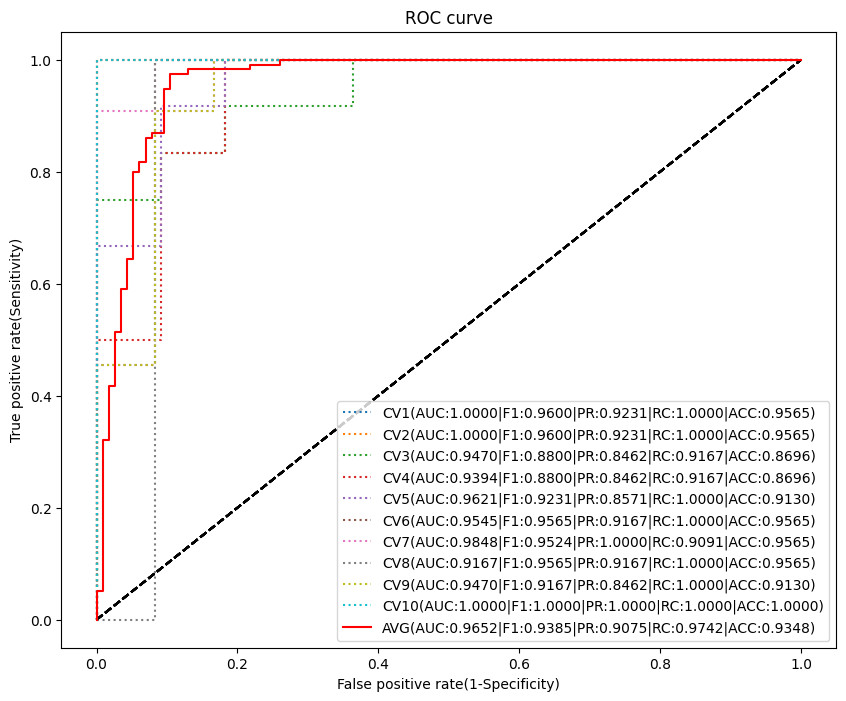


========================Blind Test=========================

230 train samples for CV
58 test samples for blind-test

Over sampling: 230 -> 230
Add train samples: 26
256 new train samples for CV



d:\Anaconda3\envs\tf28\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Learning rate: 0.00000010
Epoch 1/200


C:\Users\dell\AppData\Local\Temp\ipykernel_28484\4287042063.py:400: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


======================EPOCH 000001:======================
   epoch      loss       acc  val_loss  val_acc      rocp   f1     rfa
0    1.0  0.693718  0.457031  0.692654      0.5  0.681332  0.0  0.3794
RFA : 0.37939952437574315
8/8 - 7s - loss: 0.6937 - accuracy: 0.4570 - val_loss: 0.6927 - val_accuracy: 0.5000 - lr: 2.0010e-04 - 7s/epoch - 827ms/step
Learning rate: 0.00020010
Epoch 2/200
======================EPOCH 000002:======================
   epoch      loss       acc  val_loss   val_acc      rocp        f1       rfa
1    2.0  0.692399  0.539062  0.691797  0.586207  0.775268  0.707317  0.685314
RFA : 0.685313656751132
8/8 - 1s - loss: 0.6924 - accuracy: 0.5391 - val_loss: 0.6918 - val_accuracy: 0.5862 - lr: 4.0010e-04 - 564ms/epoch - 71ms/step
Learning rate: 0.00040010
Epoch 3/200
======================EPOCH 000003:======================
   epoch      loss     acc  val_loss   val_acc     rocp        f1       rfa
2    3.0  0.691042  0.5625  0.689153  0.706897  0.80975  0.767123  0.7

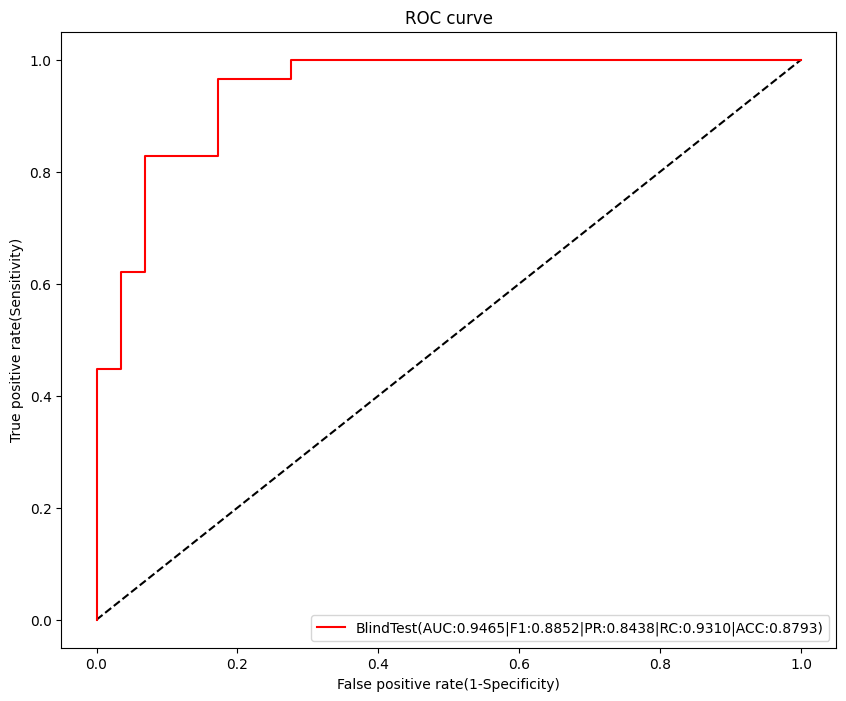


========================CV Total=========================

        acc      prec    recall        f1      rocp
0  0.956522  0.923077  1.000000  0.960000  1.000000
1  0.956522  0.923077  1.000000  0.960000  1.000000
2  0.869565  0.846154  0.916667  0.880000  0.946970
3  0.869565  0.846154  0.916667  0.880000  0.939394
4  0.913043  0.857143  1.000000  0.923077  0.962121
5  0.956522  0.916667  1.000000  0.956522  0.954545
6  0.956522  1.000000  0.909091  0.952381  0.984848
7  0.956522  0.916667  1.000000  0.956522  0.916667
8  0.913043  0.846154  1.000000  0.916667  0.946970
9  1.000000  1.000000  1.000000  1.000000  1.000000
             acc       prec     recall         f1       rocp
count  10.000000  10.000000  10.000000  10.000000  10.000000
mean    0.934783   0.907509   0.974242   0.938517   0.965152
std     0.042253   0.059247   0.041525   0.038163   0.029493
min     0.869565   0.846154   0.909091   0.880000   0.916667
25%     0.913043   0.848901   0.937500   0.918269   0.946970
50

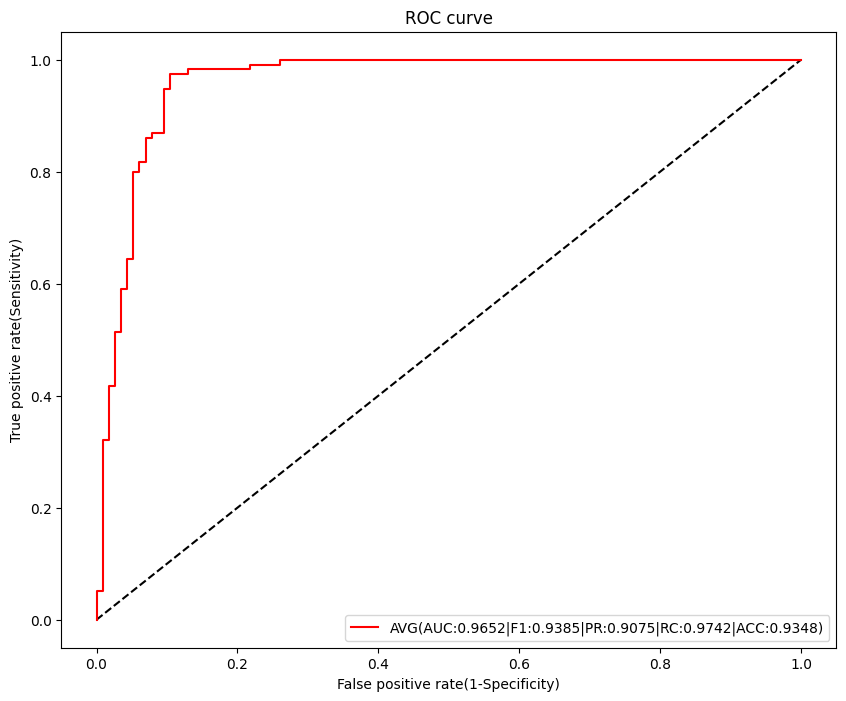




b51s2100v10s2100-stf_dn0mm10_osbfv2b_mlite-d25_b32e200clr2lr01-85frpt-v190s10

Run time: 1303.2767684459686




In [8]:
##cv_partial
if cv_partial:
    n_cv_partial=min(n_cv_partial,df_train.shape[0])
    rnd_cv_partial=np.random.RandomState(cv_partial_seed)
    cv_sel=rnd_cv_partial.choice(df_train.shape[0],n_cv_partial,replace=False)
    data_cv=data_cv[cv_sel]
    label_cv=label_cv[cv_sel]
    bt_cv=bt_cv[cv_sel]
    df_train=df_train.iloc[cv_sel,:]
    df_train_std=df_train_std.iloc[cv_sel,:]

##save and tracking
if save_ds:
    df_train.to_csv(outdata_dir+"/df_train.csv",index=False)
    df_train_std.to_csv(outdata_dir+"/df_train_std.csv",index=False)
    df_test.to_csv(outdata_dir+"/df_test.csv",index=False)
    df_test_std.to_csv(outdata_dir+"/df_test_std.csv",index=False)

    data_cv[:,-1]=ids_cv
    data_out[:,-1]=ids_out

if cv_as_all:
    data_cv=np.concatenate((data_cv,data_out),axis=0)
    label_cv=np.concatenate((label_cv,label_out),axis=0)
    bt_cv=np.concatenate((bt_cv,bt_out),axis=0)

if cv_mode=="RND":
    splits_cv=make_cv_splits(data_cv,label_cv,n_cv_splits,cv_seed)
elif cv_mode=="BTRND" or cv_mode=="CTRND":
    if cv_mode=="BTRND":
        bt_ct_all=bt_all
        bt_ct_cv=bt_cv

    splits_cv=[]
    for i in range(n_cv_splits):
        splits_cv.append([[],[],[],[]])
    for bc in bt_ct_all:
        bc_ids=np.where(bt_ct_cv==bc)[0]
        splits_cv_bc=make_cv_splits(data_cv[bc_ids],label_cv[bc_ids],
                                    n_cv_splits,cv_seed)
        for i in range(n_cv_splits):
            for j in range(4):
                splits_cv[i][j].append(splits_cv_bc[i][j])
    for i in range(n_cv_splits):
        for j in range(4):
            splits_cv[i][j]=np.concatenate(splits_cv[i][j],axis=0)

if save_ds:
    def save_cv_ds(i, cv_type):
        cv_dir=outdata_dir+"/cv%03d"%(i+1)
        if not os.path.isdir(cv_dir):
            os.makedirs(cv_dir)

        if cv_type=="train":
            ds_pos=0
        else:
            ds_pos=2

        data_cvtt=splits_cv[i][ds_pos]
        snos=np.copy(data_cvtt[:,-1])
        data_cvtt[:,-1]=data_cvtt[:,-2]

        df_cvtt_org=df_cvtt_org.reset_index(drop=True)
        df_cvtt_org.to_csv(cv_dir+"/%s.csv"%cv_type,index=False)

        df_cvtt=pd.DataFrame(np.copy(data_cvtt),columns=cols_new)
        df_cvtt["label"]=splits_cv[i][ds_pos+1]
        df_cvtt.to_csv(cv_dir+"/%s_std.csv"%cv_type,index=False)
    for i in range(n_cv_splits):
        save_cv_ds(i, "train")
        save_cv_ds(i, "val")
    data_cv[:,-1]=data_cv[:,-2]
    data_out[:,-1]=data_out[:,-2]


start=time.time()

df_hist = pd.DataFrame()
hist_acc = []
hist_prec = []
hist_recall = []
hist_f1 = []
hist_rocp = []
y_allcv = np.array([],dtype=int)
rocp_allcv = np.array([],dtype=float)

n_cv=0
for split_cv in splits_cv: 
    n_cv+=1
    if tb_enabled or conf_permtest!="":
        break
    print("\n=====================CV[%s]========================\n"%n_cv)
    in_cv = True

    (x_train_org,y_train_org,x_test_org,y_test_org)=split_cv

    y_train_cat = to_categorical(y_train_org, num_classes)
    y_test_cat = to_categorical(y_test_org, num_classes)
    y_test_watch=y_test_cat[:,watch_cls]

    print(x_train_org.shape[0], 'train samples')
    print(x_test_org.shape[0], 'test samples\n')

    x_train_dl = np.reshape(x_train_org,[-1,img_rows,img_cols,channels])
    x_test_dl = np.reshape(x_test_org,[-1,img_rows,img_cols,channels])

    y_train_dl = y_train_cat
    y_test_dl = y_test_cat

    x_train_dl,y_train_bf=fix_batch(
            batch_size_cv,osbfb_seed,x_train_dl,y_train_org,
            train_ros,batch_fix)
    y_train_dl = to_categorical(y_train_bf, num_classes)
    x_train_org = np.reshape(x_train_dl,[x_train_dl.shape[0],-1])
    y_train_org = y_train_bf
    y_train_cat = y_train_dl
    print(x_train_org.shape[0], 'new train samples\n')

    if enable_dl:
        del(model)
        model = create_dlmodel()

        if need_training_cv:
            callbacks_cv = callbacks_dl.copy()

            csv_logger = keras.callbacks.CSVLogger(log_dir+"/hist_cv%d.csv"%n_cv)
            callbacks_cv.append(csv_logger)

            if use_clr:
                step_size=math.ceil(
                        x_train_dl.shape[0]/batch_size_cv)*epochs_clr_cv 
                clr = CyclicLR(base_lr=base_lr,max_lr=max_lr_cv,
                               step_size=step_size,mode=step_mode)
                callbacks_cv[0]=clr

            if data_augmentation:
                if mix_enable:
                    from mixup_generator import MixupGenerator
                    generator_cv = MixupGenerator(x_train_dl,y_train_dl,
                                                batch_size=batch_size_cv,
                                                alpha=mix_alpha, 
                                                datagen=datagen if mix_datagen else None,
                                                )()
                else:
                    generator_cv = datagen.flow(x_train_dl,y_train_dl,
                                                 batch_size=batch_size_cv,
                                                 shuffle=True,seed=2100)

            if not data_augmentation:
                model.fit(x_train_dl,y_train_dl, 
                          batch_size=batch_size_cv,
                          epochs=epochs_cv,
                          verbose=verbose_dl,
                          shuffle=True,
                          callbacks=callbacks_cv,
                          validation_data=(x_test_dl,y_test_dl), #y_test_cat y_test_org
                          )
            else:
                model.fit_generator(
                            generator=generator_cv,workers=1,
                            epochs=epochs_cv,
                            validation_data=(x_test_dl,y_test_dl),
                            steps_per_epoch=x_train_dl.shape[0] // batch_size_cv,
                            callbacks=callbacks_cv,
                            use_multiprocessing=False, #True False
                            verbose=verbose_dl)
            model.save_weights(save_dir+"/"+conf_tags_dl+"_cv%d_last.h5"%n_cv)

        if cv_using_selflast:
            model.load_weights(save_dir+"/"+conf_tags_dl+"_cv%d_last.h5"%n_cv)
            label_out_pred_prob_d = model.predict(x_test_dl)

            if cv_using_selfbest:
                label_out_pred_d = np.argmax(label_out_pred_prob_d,axis=1)
                label_out_pred_m = label_out_pred_d
                label_out_pred=np.asarray(label_out_pred_m==watch_cls,dtype=np.int32)
                label_out_pred_prob = label_out_pred_prob_d[:,watch_cls]

                print(classification_report(y_test_org, label_out_pred_m))
                print(confusion_matrix(y_test_org, label_out_pred_m))
                print("ACCURACY:", accuracy_score(y_test_org, label_out_pred_m))
                print("PRECISION:", precision_score(y_test_watch, label_out_pred))
                print("RECALL:", recall_score(y_test_watch, label_out_pred))
                print("F1:", f1_score(y_test_watch, label_out_pred))
                print("ROC_AUC(Pr.):", roc_auc_score(y_test_watch, label_out_pred_prob))

        if cv_using_selfbest:
            model.load_weights(save_dir+"/"+conf_tags_dl+"_cv%d.h5"%n_cv)
            label_out_pred_prob_d = model.predict(x_test_dl)

        label_out_pred_d = np.argmax(label_out_pred_prob_d,axis=1)
        label_out_pred_m = label_out_pred_d
        label_out_pred=np.asarray(label_out_pred_m==watch_cls,dtype=np.int32)
        label_out_pred_prob = label_out_pred_prob_d[:,watch_cls]

        print(classification_report(y_test_org, label_out_pred_m))
        print(confusion_matrix(y_test_org, label_out_pred_m))
        print("ACCURACY:", accuracy_score(y_test_org, label_out_pred_m))
        print("PRECISION:", precision_score(y_test_watch, label_out_pred))
        print("RECALL:", recall_score(y_test_watch, label_out_pred))
        print("F1:", f1_score(y_test_watch, label_out_pred))
        print("ROC_AUC(Pr.):", roc_auc_score(y_test_watch, label_out_pred_prob))

    if enable_x:
        print('\n')
        dtrain_cv = xgb.DMatrix(x_train_org,label=y_train_org,feature_names=cols_new)
        dval = xgb.DMatrix(x_test_org,label=y_test_org,feature_names=cols_new)
        watchlist  = [(dval,'eval'), (dtrain_cv,'train')]

        bst = xgb.train(param_xgb, dtrain_cv, num_round_xgb,
                        evals=watchlist,
                        verbose_eval=25)



        label_out_pred_prob_x = bst.predict(dval,output_margin=True,
                                            ntree_limit=ntree_limit)
        label_out_pred_prob_x = clf_sigmoid(label_out_pred_prob_x)
        label_out_pred_x = np.argmax(label_out_pred_prob_x,axis=1)
        label_out_pred_m = label_out_pred_x
        label_out_pred=np.asarray(label_out_pred_m==watch_cls,dtype=np.int32)
        label_out_pred_prob = label_out_pred_prob_x[:,watch_cls]

        print(classification_report(y_test_org, label_out_pred_m))
        print(confusion_matrix(y_test_org, label_out_pred_m))
        print("ACCURACY:", accuracy_score(y_test_org, label_out_pred_m))
        print("PRECISION:", precision_score(y_test_watch, label_out_pred))
        print("RECALL:", recall_score(y_test_watch, label_out_pred))
        print("F1:", f1_score(y_test_watch, label_out_pred))
        print("ROC_AUC(Pr.):", roc_auc_score(y_test_watch, label_out_pred_prob))

    if enable_sk:
        print('\n')
        ml.fit(x_train_org, y_train_org)

        label_out_pred_prob_sk = ml.predict_proba(x_test_org)
        label_out_pred_sk = np.argmax(label_out_pred_prob_sk,axis=1)
        label_out_pred_m = label_out_pred_sk
        label_out_pred=np.asarray(label_out_pred_m==watch_cls,dtype=np.int32)
        label_out_pred_prob = label_out_pred_prob_sk[:,watch_cls]

        print(classification_report(y_test_org, label_out_pred_m))
        print(confusion_matrix(y_test_org, label_out_pred_m))
        print("ACCURACY:", accuracy_score(y_test_org, label_out_pred_m))
        print("PRECISION:", precision_score(y_test_watch, label_out_pred))
        print("RECALL:", recall_score(y_test_watch, label_out_pred))
        print("F1:", f1_score(y_test_watch, label_out_pred))
        print("ROC_AUC(Pr.):", roc_auc_score(y_test_watch, label_out_pred_prob))

    if enable_x and enable_sk:
        label_out_pred_prob_hyb = label_out_pred_prob_x*(1-w_sk) + label_out_pred_prob_sk*w_sk
    elif enable_x:
        label_out_pred_prob_hyb = label_out_pred_prob_x
    elif enable_sk:
        label_out_pred_prob_hyb = label_out_pred_prob_sk
    if enable_dl:
        if not enable_x and not enable_sk:
            label_out_pred_prob_hyb = label_out_pred_prob_d
        else:
            label_out_pred_prob_hyb = label_out_pred_prob_hyb*(1-w_dl) + label_out_pred_prob_d*w_dl
    label_out_pred_hyb = np.argmax(label_out_pred_prob_hyb,axis=1)
    label_out_pred_m = label_out_pred_hyb
    label_out_pred=np.asarray(label_out_pred_m==watch_cls,dtype=np.int32)
    label_out_pred_prob = label_out_pred_prob_hyb[:,watch_cls]

    print('\n')
    print(classification_report(y_test_org, label_out_pred_m))
    print(confusion_matrix(y_test_org, label_out_pred_m))
    print("ACCURACY:", accuracy_score(y_test_org, label_out_pred_m))
    print("PRECISION:", precision_score(y_test_watch, label_out_pred))
    print("RECALL:", recall_score(y_test_watch, label_out_pred))
    print("F1:", f1_score(y_test_watch, label_out_pred))
    print("ROC_AUC(Pr.):", roc_auc_score(y_test_watch, label_out_pred_prob))

    hist_acc.append(accuracy_score(y_test_org, label_out_pred_m))
    hist_prec.append(precision_score(y_test_watch, label_out_pred))
    hist_recall.append(recall_score(y_test_watch, label_out_pred))
    hist_f1.append(f1_score(y_test_watch, label_out_pred))
    hist_rocp.append(roc_auc_score(y_test_watch, label_out_pred_prob))

    y_allcv = np.concatenate([y_allcv,y_test_watch])
    rocp_allcv = np.concatenate([rocp_allcv,label_out_pred_prob])

    fpr_oc, tpr_oc, _ = roc_curve(
        y_test_watch,label_out_pred_prob,pos_label=1)
    plt.figure(6661,figsize=(10,8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_oc, tpr_oc, ':',
             label='CV%s(AUC:%0.4f|F1:%0.4f|PR:%0.4f|RC:%0.4f|ACC:%0.4f)'
             % (str(n_cv),hist_rocp[-1],hist_f1[-1],
                hist_prec[-1],hist_recall[-1],hist_acc[-1])
             )

df_hist["acc"] = np.array(hist_acc,dtype=float)
df_hist["prec"] = np.array(hist_prec,dtype=float)
df_hist["recall"] = np.array(hist_recall,dtype=float)
df_hist["f1"] = np.array(hist_f1,dtype=float)
df_hist["rocp"] = np.array(hist_rocp,dtype=float)
    
fpr_allcv, tpr_allcv, _ = roc_curve(
        y_allcv,rocp_allcv,pos_label=1)

print(df_hist.describe())

plt.plot(fpr_allcv, tpr_allcv, 'r-',
            label='AVG(AUC:%0.4f|F1:%0.4f|PR:%0.4f|RC:%0.4f|ACC:%0.4f)'
            % (
            df_hist.rocp.mean(),
            df_hist.f1.mean(),
            df_hist.prec.mean(),
            df_hist.recall.mean(),
            df_hist.acc.mean()
            ))

plt.xlabel('False positive rate(1-Specificity)')
plt.ylabel('True positive rate(Sensitivity)')
plt.title('ROC curve' )
plt.legend(loc='best')

plt.savefig(log_dir+"/roc-cvs.png")

plt.show()


print("\n========================Blind Test=========================\n")
in_cv = False

x_cv_org = data_cv
y_cv_org = label_cv

if conf_permtest!="":
    rnd_pt=np.random.RandomState(permtest_seed)
    y_cv_org=rnd_pt.randint(0,num_classes,size=y_cv_org.shape)

x_blind_org = data_out
y_blind_org = label_out

y_cv_cat = to_categorical(y_cv_org, num_classes)
y_blind_cat = to_categorical(y_blind_org, num_classes)
y_blind_watch=y_blind_cat[:,watch_cls]

print(x_cv_org.shape[0], 'train samples for CV')
print(x_blind_org.shape[0], 'test samples for blind-test\n')

x_cv_dl = np.reshape(x_cv_org,[-1,img_rows,img_cols,channels])
x_blind_dl = np.reshape(x_blind_org,[-1,img_rows,img_cols,channels])

y_cv_dl = y_cv_cat
y_blind_dl = y_blind_cat

x_cv_dl,y_cv_bf=fix_batch(batch_size,osbfb_seed,
                          x_cv_dl,y_cv_org,
                          train_ros,batch_fix)
y_cv_dl = to_categorical(y_cv_bf, num_classes)
x_cv_org = np.reshape(x_cv_dl,[x_cv_dl.shape[0],-1])
y_cv_org = y_cv_bf
y_cv_cat = y_cv_dl
print(x_cv_org.shape[0], 'new train samples for CV\n')

if enable_dl:
    del(model)
    model = create_dlmodel()

    if need_training_bl:
        callbacks_bl = callbacks_dl.copy()

        if conf_permtest=="":
            csv_logger = keras.callbacks.CSVLogger(log_dir+"/hist_blind.csv")
            callbacks_bl.append(csv_logger)

        if use_clr:
            step_size=math.ceil(x_cv_dl.shape[0]/batch_size)*epochs_clr 
            clr = CyclicLR(base_lr=base_lr,max_lr=max_lr,
                           step_size=step_size,mode=step_mode)
            callbacks_bl[0]=clr

        if data_augmentation:
            if mix_enable:
                from mixup_generator import MixupGenerator
                generator = MixupGenerator(x_cv_dl, y_cv_dl,
                                        batch_size=batch_size,
                                        alpha=mix_alpha, 
                                        datagen=datagen if mix_datagen else None,
                                        )()
            else:
                generator = datagen.flow(x_cv_dl,y_cv_dl,
                                         batch_size=batch_size,
                                         shuffle=True,seed=2100)

        if not data_augmentation:
            model.fit(x_cv_dl, y_cv_dl, 
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=verbose_dl,
                      shuffle=True,
                      callbacks=callbacks_bl,
                      validation_data=(x_blind_dl, y_blind_dl) 
                      )
        else:
            model.fit_generator(
                        generator,workers=1,
                        epochs=epochs,
                        validation_data=(x_blind_dl,y_blind_dl),
                        steps_per_epoch=x_cv_dl.shape[0] // batch_size,
                        callbacks=callbacks_bl,
                        use_multiprocessing=False, 
                        verbose=verbose_dl)
        if conf_permtest=="":
            model.save_weights(save_dir+"/"+conf_tags_dl+"_blind_last.h5")

    if bl_using_selflast:
        model.load_weights(save_dir+"/"+conf_tags_dl+"_blind_last.h5")
        label_out_pred_prob_d = model.predict(x_blind_dl)

        if bl_using_selfbest or bl_using_cvbests:
            label_out_pred_d = np.argmax(label_out_pred_prob_d,axis=1)
            label_out_pred_m = label_out_pred_d
            label_out_pred=np.asarray(label_out_pred_m==watch_cls,dtype=np.int32)
            label_out_pred_prob = label_out_pred_prob_d[:,watch_cls]

            print(classification_report(y_blind_org, label_out_pred_m))
            print(confusion_matrix(y_blind_org, label_out_pred_m))
            print("ACCURACY:", accuracy_score(y_blind_org, label_out_pred_m))
            print("PRECISION:", precision_score(y_blind_watch, label_out_pred))
            print("RECALL:", recall_score(y_blind_watch, label_out_pred))
            print("F1:", f1_score(y_blind_watch, label_out_pred))
            print("ROC_AUC(Pr.):", roc_auc_score(y_blind_watch, label_out_pred_prob))

    if bl_using_selfbest:
        model.load_weights(save_dir+"/"+conf_tags_dl+"_blind%s.h5"%conf_permtest)
        label_out_pred_prob_d = model.predict(x_blind_dl)

        if bl_using_cvbests:
            label_out_pred_d = np.argmax(label_out_pred_prob_d,axis=1)
            label_out_pred_m = label_out_pred_d
            label_out_pred=np.asarray(label_out_pred_m==watch_cls,dtype=np.int32)
            label_out_pred_prob = label_out_pred_prob_d[:,watch_cls]

            print(classification_report(y_blind_org, label_out_pred_m))
            print(confusion_matrix(y_blind_org, label_out_pred_m))
            print("ACCURACY:", accuracy_score(y_blind_org, label_out_pred_m))
            print("PRECISION:", precision_score(y_blind_watch, label_out_pred))
            print("RECALL:", recall_score(y_blind_watch, label_out_pred))
            print("F1:", f1_score(y_blind_watch, label_out_pred))
            print("ROC_AUC(Pr.):", roc_auc_score(y_blind_watch, label_out_pred_prob))

    if bl_using_cvbests:
        w_merge_org = w_rocp*df_hist.rocp+w_f1*df_hist.f1+w_acc*df_hist.acc
        w_merge = np.exp(w_merge_org*w_merge_exp_factor)/ \
                    np.exp(w_merge_org*w_merge_exp_factor).sum()
        label_out_pred_prob_d = np.zeros_like(y_blind_dl,dtype=float)
        for i in range(1,len(splits_cv)+1):
            model.load_weights(save_dir+"/"+conf_tags_dl+"_cv%d.h5"%i)
            score = model.evaluate(x_blind_dl, y_blind_dl, verbose=0)
            print('\n')
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])
            print('\n')
            label_out_pred_prob_d += np.asarray(model.predict(x_blind_dl)) * w_merge[i-1]

    label_out_pred_d = np.argmax(label_out_pred_prob_d,axis=1)
    label_out_pred_m = label_out_pred_d
    label_out_pred=np.asarray(label_out_pred_m==watch_cls,dtype=np.int32)
    label_out_pred_prob = label_out_pred_prob_d[:,watch_cls]

    print(classification_report(y_blind_org, label_out_pred_m))
    print(confusion_matrix(y_blind_org, label_out_pred_m))
    print("ACCURACY:", accuracy_score(y_blind_org, label_out_pred_m))
    print("PRECISION:", precision_score(y_blind_watch, label_out_pred))
    print("RECALL:", recall_score(y_blind_watch, label_out_pred))
    print("F1:", f1_score(y_blind_watch, label_out_pred))
    print("ROC_AUC(Pr.):", roc_auc_score(y_blind_watch, label_out_pred_prob))
##=============================================================

##=============================================================
if enable_x:
    print('\n')
    dtrain = xgb.DMatrix(x_cv_org,label=y_cv_org,feature_names=cols_new)
    dtest = xgb.DMatrix(x_blind_org,label=y_blind_org,feature_names=cols_new)
    watchlist  = [(dtest,'eval'), (dtrain,'train')]

    bst = xgb.train(param_xgb, dtrain, num_round_xgb,
                    evals=watchlist,
                    verbose_eval=25)

    label_out_pred_prob_x = bst.predict(dtest,output_margin=True,
                                        ntree_limit=ntree_limit)
    label_out_pred_prob_x = clf_sigmoid(label_out_pred_prob_x)
    label_out_pred_x = np.argmax(label_out_pred_prob_x,axis=1)
    label_out_pred_m = label_out_pred_x
    label_out_pred=np.asarray(label_out_pred_m==watch_cls,dtype=np.int32)
    label_out_pred_prob = label_out_pred_prob_x[:,watch_cls]

    print(classification_report(y_blind_org, label_out_pred_m))
    print(confusion_matrix(y_blind_org, label_out_pred_m))
    print("ACCURACY:", accuracy_score(y_blind_org, label_out_pred_m))
    print("PRECISION:", precision_score(y_blind_watch, label_out_pred))
    print("RECALL:", recall_score(y_blind_watch, label_out_pred))
    print("F1:", f1_score(y_blind_watch, label_out_pred))
    print("ROC_AUC(Pr.):", roc_auc_score(y_blind_watch, label_out_pred_prob))

if enable_sk:
    print('\n')
    ml.fit(x_cv_org, y_cv_org)

    label_out_pred_prob_sk = ml.predict_proba(x_blind_org)
    label_out_pred_sk = np.argmax(label_out_pred_prob_sk,axis=1)
    label_out_pred_m = label_out_pred_sk
    label_out_pred=np.asarray(label_out_pred_m==watch_cls,dtype=np.int32)
    label_out_pred_prob = label_out_pred_prob_sk[:,watch_cls]

    print(classification_report(y_blind_org, label_out_pred_m))
    print(confusion_matrix(y_blind_org, label_out_pred_m))
    print("ACCURACY:", accuracy_score(y_blind_org, label_out_pred_m))
    print("PRECISION:", precision_score(y_blind_watch, label_out_pred))
    print("RECALL:", recall_score(y_blind_watch, label_out_pred))
    print("F1:", f1_score(y_blind_watch, label_out_pred))
    print("ROC_AUC(Pr.):", roc_auc_score(y_blind_watch, label_out_pred_prob))

if enable_x and enable_sk:
    label_out_pred_prob_hyb = label_out_pred_prob_x*(1-w_sk) + label_out_pred_prob_sk*w_sk
elif enable_x:
    label_out_pred_prob_hyb = label_out_pred_prob_x
elif enable_sk:
    label_out_pred_prob_hyb = label_out_pred_prob_sk
if enable_dl:
    if not enable_x and not enable_sk:
        label_out_pred_prob_hyb = label_out_pred_prob_d
    else:
        label_out_pred_prob_hyb = label_out_pred_prob_hyb*(1-w_dl) + label_out_pred_prob_d*w_dl
label_out_pred_hyb = np.argmax(label_out_pred_prob_hyb,axis=1)
label_out_pred_m = label_out_pred_hyb
label_out_pred=np.asarray(label_out_pred_m==watch_cls,dtype=np.int32)
label_out_pred_prob = label_out_pred_prob_hyb[:,watch_cls]

print('\n')
print(classification_report(y_blind_org, label_out_pred_m))
print(confusion_matrix(y_blind_org, label_out_pred_m))
print("ACCURACY:", accuracy_score(y_blind_org, label_out_pred_m))
print("PRECISION:", precision_score(y_blind_watch, label_out_pred))
print("RECALL:", recall_score(y_blind_watch, label_out_pred))
print("F1:", f1_score(y_blind_watch, label_out_pred))
print("ROC_AUC(Pr.):", roc_auc_score(y_blind_watch, label_out_pred_prob))

if conf_permtest=="":
    fpr_oc, tpr_oc, _ = roc_curve(
        y_blind_watch,label_out_pred_prob,pos_label=1)
    plt.figure(8881,figsize=(10,8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_oc, tpr_oc, 'r-',
             label='BlindTest(AUC:%0.4f|F1:%0.4f|PR:%0.4f|RC:%0.4f|ACC:%0.4f)'
             % (roc_auc_score(y_blind_watch, label_out_pred_prob),
               f1_score(y_blind_watch, label_out_pred),
               precision_score(y_blind_watch, label_out_pred),
               recall_score(y_blind_watch, label_out_pred),
               accuracy_score(y_blind_org, label_out_pred_m)))
    plt.xlabel('False positive rate(1-Specificity)')
    plt.ylabel('True positive rate(Sensitivity)')
    plt.title('ROC curve' )
    plt.legend(loc='best')
    plt.savefig(log_dir+"/roc-blind.png")
    plt.show()
    

df_blind=pd.DataFrame()
df_blind["pred_prob"]=label_out_pred_prob
df_blind["real_label"]=y_blind_watch
if conf_permtest=="":
    df_blind_file=log_dir+"/df-blind-pred.csv"
else:
    df_blind_file=log_dir+"/df-blind-pred%s_%d.csv"%(conf_permtest,
                                                     int(round(roc_auc_score(y_blind_watch, label_out_pred_prob)*10000,0)))
df_blind.to_csv(df_blind_file,index=False)


if conf_permtest=="" and not tb_enabled:
    print("\n========================CV Total=========================\n")
    print(df_hist)
    print(df_hist.describe())

    rocp_avg = roc_auc_score(y_allcv, rocp_allcv)
    pred_allcv = np.asarray(rocp_allcv>0.5,dtype=np.int32)
    fpr_oc, tpr_oc, _ = roc_curve(
        y_allcv,rocp_allcv,pos_label=1)
    plt.figure(6661,figsize=(10,8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_oc, tpr_oc, 'r-',
             label='AVG(AUC:%0.4f|F1:%0.4f|PR:%0.4f|RC:%0.4f|ACC:%0.4f)'
             % (

                df_hist.rocp.mean(),
                df_hist.f1.mean(),
                df_hist.prec.mean(),
                df_hist.recall.mean(),
                df_hist.acc.mean()
                ))
    plt.xlabel('False positive rate(1-Specificity)')
    plt.ylabel('True positive rate(Sensitivity)')
    plt.title('ROC curve' )
    plt.legend(loc='best')
    # plt.savefig(log_dir+"/roc-cvs.png")
    plt.show()
    

    df_cvs=pd.DataFrame()
    df_cvs["pred_prob"]=rocp_allcv
    df_cvs["real_label"]=y_allcv
    df_cvs.to_csv(log_dir+"/df-cvs-pred.csv",index=False)
print("")
print("\n===========================================================================\n")
print(conf_tags)
print("\nRun time:", time.time()-start)
print("\n===========================================================================\n")